In [2]:
#! /usr/bin/env python                                                                                            
# Run PSFEx for a set of exposures, including making any necessarily input files.                                 
# It also logs errors into a psf blacklist file.                                                                  
# Functions stolen from:                                                                                          
# https://github.com/rmjarvis/DESWL/blob/master/psf/run_piff.py                                                                                                                                        
# Probably lots of extraneous parameters and flags as well...   

!jupyter nbconvert --to script MeasurePSFres_new.ipynb

from __future__ import print_function
import os
import sys
import shutil
import logging
import datetime
import traceback
import numpy as np
import copy
import glob
import time
import fitsio
#import pixmappy
import pandas as pd
import galsim
import galsim.des
import piff
import ngmix
from astropy.io import fits
import wget
from astropy.wcs import WCS
from ngmix import priors, joint_prior
import random
import pylab as P
import warnings

import matplotlib
#matplotlib.use('Agg') # needs to be done before import pyplot                                                    
import matplotlib.pyplot as plt

[NbConvertApp] Converting notebook MeasurePSFres_new.ipynb to script
[NbConvertApp] Writing 51091 bytes to MeasurePSFres_new.py


In [3]:
# Don't skip columns in describe output  (default is 20, which is a bit too small)                                
pd.options.display.max_columns = 200 

# Define the parameters for the blacklist                                                                         
# AC note:  a lot of these settings are not really used for the deep fields                                       
# currently...!   

# How many stars are too few or too many? 
FEW_STARS = 25
MANY_STARS_FRAC = 0.3
# How high is a high FWHM?  3.6 arcsec / 0.26 arcsec/pixel = 13.8 pixels                                          
#HIGH_FWHM = 13.8                                                                                                 
HIGH_FWHM = 3.6  # (We switched to measuring this in arcsec)                                                      
NSIG_T_OUTLIER = 4   # How many sigma for a chip to be an outlier in <T>.                                         

# Not copying flag vals for blacklist and psf catalog...                                                          
rng = galsim.BaseDeviate(1234)
MAX_CENTROID_SHIFT = 1.0
NOT_USED = 1
BAD_MEASUREMENT = 2
CENTROID_SHIFT = 4
OUTLIER = 8
FAILURE = 32
RESERVED = 64
NOT_STAR = 128
BLACK_FLAG_FACTOR = 512 # blacklist flags are this times the original exposure blacklist flag                     
# blacklist flags go up to 64,       

# Not copying array to convert ccdnum to detpos (this may or may not                                              
# be important)     

In [4]:
#put the stars data into a dataframe 

def read_psfex_stars(star_file, cat_file, logger): #combination of read findstars and read_image_header in MJ script
    """Read the PSFEx star selection                                                                              
    """
    print(star_file)
    if not os.path.exists(star_file):
        return None
    #dat = fits.open(star_file)
    #print(dat[2].columns)
    #dat = fits.open(cat_file)
    #print(dat[2].columns)
    
    # Read the output and make a DataFrome with the contents                                                      
    data = fitsio.read(star_file, ext=2)
    data = data.astype(data.dtype.newbyteorder('='))
    #print("TESTING")
    flags_psf = data['FLAGS_PSF']
    source_id = data['SOURCE_NUMBER']
    x_im = data['X_IMAGE']
    y_im = data['Y_IMAGE']
    df = pd.DataFrame(data={'SOURCE_NUMBER':source_id, 'X_IMAGE':x_im,
                          'Y_IMAGE':y_im, 'FLAGS_PSF':flags_psf})
    #print(df)

    ntot = len(df)
    nstars = df['FLAGS_PSF'].sum()
    print('   found %d stars',ntot,nstars)
    logger.info('   found %d stars',nstars)
    #is_star = df['FLAGS_PSF'] == 1
    #print
    #print('   found %d good stars', len(is_star))

    # Add on some extra information from the sextractor catalog                                                   
    sdata = fitsio.read(cat_file, 2)
    #print(data['X_IMAGE'])
    #print(sdata['X_IMAGE'])
    print(len(data),len(sdata))
    assert len(data) == len(sdata)
    #print("magaper")
    #print(sdata['MAG_APER'])
    #print(sdata['MAG_APER'].shape)
    df['mag_aper'] = sdata['MAG_APER'][:,8]
    df['flux_radius'] = sdata['FLUX_RADIUS']
    #df['mag_auto'] = sdata['MAG_AUTO']
    '''
    #df = df[df.FLAGS_PSF == 0] #this line doesn't work!!!!!!!
    #print('   found %d good stars', len(df))
    plt.scatter(sdata['MAG_APER'][:,8], sdata['FLUX_RADIUS'],c='blue',label='FLAGS_PSF!=0 : %d' % (len(sdata['FLUX_RADIUS'])), marker='.',s=4) # , colormap='viridis')
    plt.scatter(sdata['MAG_APER'][np.where(data['FLAGS_PSF'] == 0),8], sdata['FLUX_RADIUS'][np.where(data['FLAGS_PSF'] == 0)],c='red',label='FLAGS_PSF==0 :%d' % (len(sdata['FLUX_RADIUS'][np.where(data['FLAGS_PSF'] == 0)])), marker='.',s=4) # , colormap='viridis')
    #plt.scatter(sdata['MAG_AUTO'], sdata['FLUX_RADIUS'],c='blue',label='FLAGS_PSF!=0 : %d' % (len(sdata['FLUX_RADIUS'])), marker='.',s=4) # , colormap='viridis')
    #plt.scatter(sdata['MAG_AUTO'][np.where(data['FLAGS_PSF'] == 0)], sdata['FLUX_RADIUS'][np.where(data['FLAGS_PSF'] == 0)],c='red',label='FLAGS_PSF==0 :%d' % (len(sdata['FLUX_RADIUS'][np.where(data['FLAGS_PSF'] == 0)])), marker='.',s=4) # , colormap='viridis')
  
    #plt.scatter(df['mag_aper'], df['flux_radius'], c='red',label='FLAGS_PSF==0', marker='.',s=4) # , colormap='viridis')
    plt.xlim((10,28))
    plt.ylim(0,10)
    #axs2[i].legend(sexstar['FLAGS_PSF'])
    plt.ylabel('FLUX_RADIUS')
    plt.xlabel('MAG_APER[:,8]')
    #plt.xlabel('MAG_AUTO')
    plt.title('%s'% band)
    plt.legend()
    plt.show()'''
    
    return df

In [4]:
#this is just a dublicate from the end in order to test why my mag_apers for "good" galaxies were higher than expected
"""
# Change locations to yours      
cdir = '/global/cscratch1/sd/aamon/DEEP/UVista'
cdir2= '/global/cscratch1/sd/amichoi/UltraVISTA'                                            

#band =  "J" #H, Ks, Y
bands=["J" ]#, "H", "Ks", "Y"]

for band in bands:
    print(band)
    
    pf = '%s/psf/UVISTA_%s_21_01_16_psfcat.psf' % (cdir2, band) # PSFEx image
    sf= '%s/psf/UVISTA_%s_21_01_16_psfex-starlist.fits' % (cdir2, band) #list of stars made from Sextractor and PSFEx
    cf = '%s/cat/UVISTA_%s_21_01_16_psfcat.fits' % (cdir2, band) #the output from extractor 
    im_f = '%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.fits' % (cdir, band)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
    wt_f = '%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.weight.fits'%(cdir, band)   

    full_image = galsim.fits.read(im_f, hdu=0)
    wcs = full_image.wcs
    hdu = 0
    f = fitsio.FITS(im_f)
    header_list = f[hdu].read_header_list()
    header_list = [ d for d in header_list if 'CONTINUE' not in d['name'] ]
    h = fitsio.FITSHDR(header_list)
    #print(h)
    fwhm = h['PSF_FWHM']
    
    magzp = 30.0     
    mmlogging_level = logging.INFO
    logger = logging.getLogger('size_residual')
    df = read_psfex_stars(sf, cf, magzp, logger)
    """

'\n# Change locations to yours      \ncdir = \'/global/cscratch1/sd/aamon/DEEP/UVista\'\ncdir2= \'/global/cscratch1/sd/amichoi/UltraVISTA\'                                            \n\n#band =  "J" #H, Ks, Y\nbands=["J" ]#, "H", "Ks", "Y"]\n\nfor band in bands:\n    print(band)\n    \n    pf = \'%s/psf/UVISTA_%s_21_01_16_psfcat.psf\' % (cdir2, band) # PSFEx image\n    sf= \'%s/psf/UVISTA_%s_21_01_16_psfex-starlist.fits\' % (cdir2, band) #list of stars made from Sextractor and PSFEx\n    cf = \'%s/cat/UVISTA_%s_21_01_16_psfcat.fits\' % (cdir2, band) #the output from extractor \n    im_f = \'%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.fits\' % (cdir, band)  #VIDEO_H_10_34.31_-4.80.cleaned.fits\n    wt_f = \'%s/UVISTA_%s_21_01_16_allpaw_skysub_015_dr3_rc_v5.weight.fits\'%(cdir, band)   \n\n    full_image = galsim.fits.read(im_f, hdu=0)\n    wcs = full_image.wcs\n    hdu = 0\n    f = fitsio.FITS(im_f)\n    header_list = f[hdu].read_header_list()\n    header_list = [ d for d in head

In [5]:
def make_ngmix_prior(T, pixel_scale):
    # centroid is 1 pixel gaussian in each direction
    cen_prior=priors.CenPrior(0.0, 0.0, pixel_scale, pixel_scale)
    #print("1 ", cen_prior)
    # g is Bernstein & Armstrong prior with sigma = 0.1
    gprior=priors.GPriorBA(0.1)
    #print("2 ", gprior)
    #print("2b ",  T)
    #print(priors.LogNormal(T, 0.2))
    # T is log normal with width 0.2
    Tprior=priors.LogNormal(T, 0.2)
    #print("3 ", Tprior)
    # flux is the only uninformative prior
    Fprior=priors.FlatPrior(-10.0, 1.e10)
    #print("4 ", Fprior)
    prior=joint_prior.PriorSimpleSep(cen_prior, gprior, Tprior, Fprior)
    return prior


def ngmix_fit(im, wt, fwhm, x, y, logger, psfflag):     
    flag = 0
    dx, dy, g1, g2, flux = 0., 0., 0., 0., 0.
    T_guess = (fwhm / 2.35482)**2 * 2.
    T = T_guess
    #print('fwhm = %s, T_guess = %s'%(fwhm, T_guess))
    if psfflag==0:
        
            #hsm_dx,hsm_dy,hsm_g1,hsm_g2,hsm_T,hsm_flux,hsm_flag = hsm(im, None, logger)
            #logger.info('hsm: %s, %s, %s, %s, %s, %s, %s',hsm_dx,hsm_dy,hsm_g1,hsm_g2,hsm_T,hsm_flux,hsm_flag)
            #if hsm_flag != 0:
                #print('hsm: ',g1,g2,T,flux,hsm_flag)
                #print('Bad hsm measurement.  Reverting to g=(0,0) and T=T_guess = %s'%(T_guess))
                #T = T_guess
            #elif np.abs(np.log(T/T_guess)) > 0.5:
                #print('hsm: ',g1,g2,T,flux,hsm_flag)
                #print('T = %s is not near T_guess = %s.  Reverting to T_guess'%(T,T_guess))
            #T = T_guess
        #print("before wcs.local")
        #print(im.wcs.local)
        #print("before im.center")
        #print(im.true_center)
        #print("this line ", im.wcs.local(im.true_center))
        wcs = im.wcs.local(im.true_center)
        #print(wcs)
        try:
            #print("going to make prior", T,wcs.minLinearScale())
            prior = make_ngmix_prior(T, wcs.minLinearScale())
            #print("prior", prior)
        
            if galsim.__version__ >= '1.5.1':
                cen = im.true_center - im.origin
            else:
                cen = im.trueCenter() - im.origin()
            jac = ngmix.Jacobian(wcs=wcs, x=cen.x + x - int(x+0.5), y=cen.y + y - int(y+0.5))
            if wt is None:
                obs = ngmix.Observation(image=im.array, jacobian=jac)
            else:
                obs = ngmix.Observation(image=im.array, weight=wt.array, jacobian=jac)

            lm_pars = {'maxfev':4000}
            runner=ngmix.bootstrap.PSFRunner(obs, 'gauss', T, lm_pars, prior=prior)
            runner.go(ntry=3)

            ngmix_flag = runner.fitter.get_result()['flags']
            gmix = runner.fitter.get_gmix()
        except Exception as e:
            logger.info(e)
            logger.info(' *** Bad measurement (caught exception).  Mask this one.')
            print(' *** Bad measurement (caught exception).  Mask this one.')
            flag |= BAD_MEASUREMENT
            return dx,dy,g1,g2,T,flux,flag

        if ngmix_flag != 0:
            logger.info(' *** Bad measurement (ngmix flag = %d).  Mask this one.',ngmix_flag)
            flag |= BAD_MEASUREMENT
            print(' *** Bad measurement (ngmix flag = %d).  Mask this one.',ngmix_flag)

        dx, dy = gmix.get_cen()
        if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
            logger.info(' *** Centroid shifted by %f,%f in ngmix.  Mask this one.',dx,dy)
            flag |= CENTROID_SHIFT
            print(' *** Centroid shifted by %f,%f in ngmix.  Mask this one.',dx,dy)

        g1, g2, T = gmix.get_g1g2T()
        if abs(g1) > 0.5 or abs(g2) > 0.5:
            logger.info(' *** Bad shape measurement (%f,%f).  Mask this one.',g1,g2)
            flag |= BAD_MEASUREMENT

        flux = gmix.get_flux() / wcs.pixelArea()  # flux is in ADU.  Should ~ match sum of pixels
    #logger.info('ngmix: %s %s %s %s %s %s %s',dx,dy,g1,g2,T,flux,flag)
    return dx, dy, g1, g2, T, flux, flag
    
#measure_star_shapes(df,im_f,noweight=False,wcs=wcs,use_ngmix=True, fwhm=FWHM,logger=logger)

In [6]:
def hsm(im, wt, logger):
    #print('im stats: ',im.array.min(),im.array.max(),im.array.mean(),np.median(im.array))                        
    #print('wt = ',wt)                                                                                            
    #if wt:                                                                                                       
        #print('im stats: ',wt.array.min(),wt.array.max(),wt.array.mean(),np.median(wt.array))                    
    flag = 0
    try:
        shape_data = im.FindAdaptiveMom(weight=wt, strict=False)
        #print('shape_data = ',shape_data)                                                                        
    except Exception as e:
        logger.info(e)
        logger.info(' *** Bad measurement (caught exception).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if shape_data.moments_status != 0:
        logger.info('status = %s',shape_data.moments_status)
        logger.info(' *** Bad measurement (hsm status).  Mask this one.')
        flag |= BAD_MEASUREMENT

    if galsim.__version__ >= '1.5.1':
        dx = shape_data.moments_centroid.x - im.true_center.x
        dy = shape_data.moments_centroid.y - im.true_center.y
    else:
        dx = shape_data.moments_centroid.x - im.trueCenter().x
        dy = shape_data.moments_centroid.y - im.trueCenter().y
    #print('dx, dy = ',dx,dy)                                                                                     
    if dx**2 + dy**2 > MAX_CENTROID_SHIFT**2:
        logger.info(' *** Centroid shifted by %f,%f in hsm.  Mask this one.',dx,dy)
        flag |= CENTROID_SHIFT

    flux = shape_data.moments_amp
    #print('flux = ',flux)                             
    
    # Account for the image wcs                                                                                   
    if im.wcs.isPixelScale():
        g1 = shape_data.observed_shape.g1
        g2 = shape_data.observed_shape.g2
        T = 2 * shape_data.moments_sigma**2 * im.scale**2
        #print('simple shape = ',g1,g2,T)                                                                         
    else:
        e1 = shape_data.observed_shape.e1
        e2 = shape_data.observed_shape.e2
        s = shape_data.moments_sigma
        #print('simple shape = ',e1,e2,s)                                                                         

        if galsim.__version__ >= '1.5.1':
            jac = im.wcs.jacobian(im.true_center)
        else:
            jac = im.wcs.jacobian(im.trueCenter())
        M = np.matrix( [[ 1 + e1, e2 ], [ e2, 1 - e1 ]] ) * s*s
        J = jac.getMatrix()
        M = J * M * J.T

        e1 = (M[0,0] - M[1,1]) / (M[0,0] + M[1,1])
        e2 = (2.*M[0,1]) / (M[0,0] + M[1,1])
        T = M[0,0] + M[1,1]

        shear = galsim.Shear(e1=e1, e2=e2)
        g1 = shear.g1
        g2 = shear.g2
        #print('distorted shape = ',g1,g2,T) 
    return dx, dy, g1, g2, T, flux, flag


In [7]:
#"Measure shapes of the raw stellar images at each location.      
def measure_star_shapes(df, image_file, weight_file,noweight, wcs, use_ngmix, fwhm, logger):
    logger.info('Read in stars in file: %s',image_file)

    ind = df.index[df['FLAGS_PSF'] == 0]
    logger.info('ind = %s',ind)
    n_psf = len(ind)
    logger.info('n_psf = %s',n_psf)

    df['obs_dx'] = [ -999. ] * len(df)
    df['obs_dy'] = [ -999. ] * len(df)
    df['obs_e1'] = [ -999. ] * len(df)
    df['obs_e2'] = [ -999. ] * len(df)
    df['obs_T'] = [ -999. ] * len(df)
    df['obs_flux'] = [ -999. ] * len(df)
    df['obs_flag'] = [ NOT_STAR ] * len(df)
    df.loc[ind, 'obs_flag'] = 0

    if 'reserve' in df:
        #print("finding reserve but I want to ignore this")
        df.loc[df['reserve'], 'obs_flag'] |= RESERVED
        df.loc[~df['use'] & ~df['reserve'], 'obs_flag'] |= NOT_USED
    #else:
        #df.loc[~df['use'], 'obs_flag'] |= NOT_USED

    #df['ra'] = sdata['ALPHAWIN_J2000']
    #df['dec'] = sdata['DELTAWIN_J2000']
    #INSTEAD I'LL USE THE WCS AND THE X,Y TO GET RA AND DEC
    full_image = galsim.fits.read(image_file, hdu=0)
    w = WCS(image_file)
    xall = df['X_IMAGE']
    yall = df['Y_IMAGE']
    
    #print(xall,yall)
    world = w.wcs_pix2world(xall,yall,1)
    #print(world)
    #print(world[0])
    df['ra'] = world[0]
    df['dec'] = world[1]
 
    if wcs is not None:
        full_image.wcs = wcs

    if not noweight:
        #print("want weights! ", weight_file)
        #weight_file = image_file.replace(".fits", ".weight.fits")
        full_weight = galsim.fits.read(weight_file, hdu=0)
        full_weight.array[full_weight.array < 0] = 0.

    stamp_size = 48

    for i in ind:
        x = df['X_IMAGE'].iloc[i]
        y = df['Y_IMAGE'].iloc[i]

        #print('Measure shape for star at ',x,y)                                                                         
        b = galsim.BoundsI(int(x)-stamp_size/2, int(x)+stamp_size/2,
                           int(y)-stamp_size/2, int(y)+stamp_size/2)
        b = b & full_image.bounds
        im = full_image[b]

        if noweight:
            wt = None
        else:
            wt = full_weight[b]
            
        if use_ngmix:
            #print("using ngmix")
            #print(df['FLAGS_PSF'][i])
            dx, dy, e1, e2, T, flux, flag = ngmix_fit(im, wt, fwhm, x, y, logger,df['FLAGS_PSF'][i])
            
        else:
            dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)
            
        #dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)
        #print(dx, dy, e1, e2, T, flux, flag)
        #logger.info('ngmix measurement: (%f,%f,%f,%f,%f,%f).',dx,dy,e1,e2,T,flux)                                       
        if np.any(np.isnan([dx,dy,e1,e2,T,flux])):
            logger.info(' *** NaN detected (%f,%f,%f,%f,%f,%f).',dx,dy,e1,e2,T,flux)
            flag |= BAD_MEASUREMENT
        else:
            df.loc[i, 'obs_dx'] = dx
            df.loc[i, 'obs_dy'] = dy
            df.loc[i, 'obs_e1'] = e1
            df.loc[i, 'obs_e2'] = e2
            df.loc[i, 'obs_T'] = T
            df.loc[i, 'obs_flux'] = flux
            df.loc[i, 'obs_flag'] |= flag
    logger.info('final obs_flag = %s',df['obs_flag'][ind].values)
    #print('df[ind] = ',df.loc[ind].describe())                                                                          
    #flag_outliers(df, ind, 'obs', 4., logger) # This needs to be ported...                                              

    # Any stars that weren't measurable here, don't use for PSF fitting.                                                 
    df.loc[df['obs_flag']!=0, 'use'] = False

In [8]:
def measure_psfex_shapes(df, psfex_file, image_file, weight_file, noweight, wcs, use_ngmix, fwhm, logger):
    """Measure shapes of the PSFEx solution at each location.                                                            
    """
    logger.info('Read in PSFEx file: %s',psfex_file)

    ind = df.index[df['FLAGS_PSF'] == 0]
    logger.info('ind = %s',ind)
    n_psf = len(ind)
    logger.info('n_psf = %s',n_psf)

    df['psfex_dx'] = [ -999. ] * len(df)
    df['psfex_dy'] = [ -999. ] * len(df)
    df['psfex_e1'] = [ -999. ] * len(df)
    df['psfex_e2'] = [ -999. ] * len(df)
    df['psfex_T'] = [ -999. ] * len(df)
    df['psfex_flux'] = [ -999. ] * len(df)
    df['psfex_flag'] = [ NOT_STAR ] * len(df)
    df.loc[ind, 'psfex_flag'] = 0

    if 'reserve' in df:
        df.loc[df['reserve'], 'psfex_flag'] |= RESERVED
    #df.loc[~df['use'], 'psfex_flag'] |= NOT_USED

    try:
        psf = galsim.des.DES_PSFEx(psfex_file, image_file)
    except Exception as e:
        logger.info('Caught %s',e)
        df.loc[ind, 'psfex_flag'] = FAILURE
        return

    full_image = galsim.fits.read(image_file, hdu=0)

    if wcs is not None:
        full_image.wcs = wcs

    if not noweight:
        #print("want weights! ", weight_file)
        #weight_file = image_file.replace(".fits", ".weight.fits")
        full_weight = galsim.fits.read(weight_file, hdu=0)
        full_weight.array[full_weight.array < 0] = 0.
    
    

    stamp_size = 48

    for i in ind:
        x = df['X_IMAGE'].iloc[i]
        y = df['Y_IMAGE'].iloc[i]
        #print('Measure PSFEx model shape at ',x,y)                                                                      
        image_pos = galsim.PositionD(x,y)
        psf_i = psf.getPSF(image_pos)

        b = galsim.BoundsI(int(x)-stamp_size/2, int(x)+stamp_size/2,
                           int(y)-stamp_size/2, int(y)+stamp_size/2)
        b = b & full_image.bounds
        im = full_image[b]

        im = psf_i.drawImage(image=im, method='no_pixel')
        im *= df['obs_flux'].iloc[i]

        if noweight:
            wt = None
        else:
            wt = full_weight[b]
            var = wt.copy()
            var.invertSelf()
            im.addNoise(galsim.VariableGaussianNoise(rng, var))
            
        if use_ngmix:
            dx, dy, e1, e2, T, flux, flag = ngmix_fit(im, wt, fwhm, x, y, logger, df['FLAGS_PSF'][i])
        else:
            dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)

        #dx, dy, e1, e2, T, flux, flag = hsm(im, wt, logger)
        if np.any(np.isnan([dx,dy,e1,e2,T,flux])):
            logger.info(' *** NaN detected (%f,%f,%f,%f,%f,%f).',dx,dy,e1,e2,T,flux)
            flag |= BAD_MEASUREMENT
        else:
            df.loc[i, 'psfex_dx'] = dx
            df.loc[i, 'psfex_dy'] = dy
            df.loc[i, 'psfex_e1'] = e1
            df.loc[i, 'psfex_e2'] = e2
            df.loc[i, 'psfex_T'] = T
            df.loc[i, 'psfex_flux'] = flux
        df.loc[i, 'psfex_flag'] |= flag
    #print('final psfex_flag = %s',df['psfex_flag'][ind].values)
    logger.info('final psfex_flag = %s',df['psfex_flag'][ind].values)
    #print('df[ind] = ',df.loc[ind].describe())                                                                          
    #flag_outliers(df, ind, 'psfex', 4., logger)                    

In [9]:
#not working
def wget( url, file):
    full_file = os.path.join(url,file)
    print(full_file)
    if not os.path.isfile(full_file):
        # Sometimes this fails with an "http protocol error, bad status line".
        # Maybe from too many requests at once or something.  So we retry up to 5 times.
        nattempts = 5
        cmd = 'wget -q --no-check-certificate %s'%(full_file)
        for attempt in range(1,nattempts+1):
            if os.path.exists(full_file):
                break
    return full_file

In [9]:
## want psf vs mag- brighter vs fatte6
def bin_by_mag(m, dT, dTfrac, min_mused, band, name):    
    
    min_mag = min(m) #13.5
    max_mag = max(m) #21
    print("min and max mag: ", min_mag, max_mag)
     
    mag_bins = np.linspace(min_mag,max_mag,21)
    #print('mag_bins = ',mag_bins)
    index = np.digitize(m, mag_bins)
    #print('len(index) = ',len(index))
    
    bin_dT = [dT[index == i].mean() for i in range(1, len(mag_bins))]
    #print('bin_dT = ',bin_dT)
    bin_dTfrac = [dTfrac[index == i].mean() for i in range(1, len(mag_bins))]
    bin_dT_err=np.zeros(len(mag_bins))
    bin_dTfrac_err=np.zeros(len(mag_bins))
    for i in range(1, len(mag_bins)) :
        
        try:
            #bin_dT_err = [ np.sqrt(dT[index == i].var() / len(dT[index == i])) for i in range(1, len(mag_bins))  ]
            #bin_dTfrac_err = [ np.sqrt(dTfrac[index == i].var() / len(dTfrac[index == i])) for i in range(1, len(mag_bins)) ]
            #
            bin_dT_err[i] =  np.sqrt(dT[index == i].var() / len(dT[index == i]))
            bin_dTfrac_err[i] =  np.sqrt(dTfrac[index == i].var() / len(dTfrac[index == i]))
            #print(bin_dTfrac_err[i])
        except ZeroDivisionError:
            #print('0 err0r ')
            bin_dT_err[i] = 0
            bin_dTfrac_err[i] = 0
  
        
    #for i in range(1, len(mag_bins)):
        #print('len(index) = ',len(dT[index == i]))
    """
    bin_dT_err=np.zeros(len(mag_bins)-1)
    for i in range(1, len(mag_bins)):
        if len(dT[index == i])==0:
            bin_dT_err[i] =0
        else:
            bin_dT_err[i] = np.sqrt(dT[index == i].var() / len(dT[index == i])) 
    print(bin_dT)
    print(bin_dT_err)  
    #bin_dT_err = [ np.sqrt(dT[index == i].var() / len(dT[index == i])) for i in range(1, len(mag_bins)) if len(dT[index == i])>0 ]
    #bin_dTfrac_err = [ np.sqrt(dTfrac[index == i].var() / len(dTfrac[index == i])) for i in range(1, len(mag_bins)) if len(dT[index == i])>0 ]
    for i in range(1, len(mag_bins)):
        print(i)
        print(len(dT[index == i]))
        #if len(dT[index == i])==0:
        print(bin_dT_err[i])
    """
    
    # Fix up nans
    for i in range(1,len(mag_bins)):
        if i not in index:
            bin_dT[i-1] = 0.
            bin_dTfrac[i-1] = 0.
            bin_dT_err[i-1] = 0.
            bin_dTfrac_err[i-1] = 0.
            
    where_are_NaNs = np.isnan(bin_dT_err)
    bin_dT_err[where_are_NaNs] = 0.
    where_are_NaNs = np.isnan(bin_dTfrac_err)
    bin_dTfrac_err[where_are_NaNs] = 0.
    print(mag_bins)
    print("here")
    print(mag_bins[1:])
    med=np.median(df['fracsizeres'])
    #print(med)
    #med=np.median(df['fracsizeres'][10:-17])
    print("median ", med)  
    
    return med, mag_bins, bin_dTfrac, bin_dTfrac_err
    """
    fig, axes = plt.subplots()   
    '''
    ax = axes[0]
    ax.set_ylim(-0.02,0.02)
    ax.plot([min_mag,max_mag], [0,0], color='black')
    ax.plot([min_mused,min_mused],[-1,1], color='Grey')
    ax.plot([19,19],[-1,1], color='Grey')
    #ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    t_line = ax.errorbar(mag_bins[:-1], bin_dT, yerr=bin_dT_err[1:], color='darkturquoise', fmt='o')
    #ax.fill( [18.0,18.,20,20], [0.01,-0.01,-0.01,0.01], fill=True, color='grey',alpha=0.3)
    #ax.axhline(y=0.003, linewidth=4, color='grey')
    #ax.legend([t_line], [r'$\delta T$'])
    ax.set_ylabel(r'$(T_{\rm PSF} - T_{\rm model}) \quad({\rm arcsec}^2)$', fontsize='x-large')
    ax.set_xlim(15.5,22)
    '''
    #ax = axes[0]
    plt.ylim(-0.05,0.05)
    plt.plot([20,20], [0,0], color='black')
    plt.plot([min_mused,min_mused],[-1,1], color='Grey')
    #plt.plot([19,19],[-1,1], color='Grey')
    plt.fill( [16.,16.,20,20], [0.01,-0.01,-0.01,0.01], fill=True, color='grey',alpha=0.3)
    plt.plot([min_mag,20], [med,med], color='darkturquoise')
    #ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
    t_line = plt.errorbar(mag_bins[:-1], bin_dTfrac, yerr=bin_dTfrac_err[1:], color='darkturquoise', fmt='o')
    #ax.legend([t_line], [r'$\delta T$'])
    plt.ylabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='x-large')

    plt.xlim(16,20)
    plt.xlabel('%s-magnitude'% (band), fontsize='x-large')

    fig.set_size_inches(7.0,6.0)
    plt.tight_layout()
    name='dpsf_%s_%s_DEEP.pdf' % (name,band)
    #plt.savefig(name)
    plt.show()
    """


In [11]:
def stickplot(x, y, xcomp, ycomp, colour, whisker_scale, labelpresent, xtickspresent, ytickspresent, clbupperlim, title=''):
    #P.figure(figsize=(16,12))                                                            
    #ax = P.subplot(111)           
    
    xsize=6
    ysize=10
    
    #fig, ax = plt.subplots()
    fig, axes = plt.subplots(2,1, sharex=True,figsize=(xsize, ysize))
    ax = axes[0]
    color_ax1 = fig.add_axes([0.4/xsize, 10.0/ysize, 1.7/xsize, 0.05/ysize])
    #color_ax2 = fig.add_axes([2.2/xsize, 10.0/ysize, 1.7/xsize, 0.05/ysize])
    ax.set_axis_bgcolor('white')
    print("check on count: ", len(x))

    theta = np.arctan2(ycomp, xcomp) / 2. #np.arctan(y,x) gives the arc tangent of y/x    
    e = np.hypot(xcomp,ycomp) #magnitude of g cmpnts                                      
    u = np.cos(theta) * e
    v = np.sin(theta) * e
    print(min(e))
    print(max(e))
    norm = P.mpl.colors.Normalize(min(colour), max(colour))  # set the color scale to a uniform value                                                                              

    #with warnings.catch_warnings():
    #  warnings.simplefilter('ignore')
    Q1 = ax.quiver(x, y, u, v, e, cmap='jet', pivot='middle',
                           headwidth=0, headlength=0, headaxislength=0, norm=norm,
                           width=0.004, scale=whisker_scale, clim=[0,clbupperlim])
    scalepercent=whisker_scale * 0.01

    #cbar = fig.colorbar(Q1, cax=ax , orientation='horizontal')
    #cbar.set_ticklabels(['0.00','0.02','0.04','0.06','0.08','0.10','0.12'])
    #cbar.ax.tick_params(labelsize=7, pad=6)

    #P.xlim([(min(ra) - 0.1),(max(ra) + 0.1)])
    #P.ylim([(min(dec) - 0.1),(max(dec) + 0.1)])
    P.xlim([(min(x) - 0.1),(max(x) + 0.1)])
    P.ylim([(min(y) - 0.1),(max(y) + 0.1)])

    ax.text(0.1, 0.88, title, transform=ax.transAxes,
              fontsize='x-small', ha='left', va='bottom', weight='bold',)

    # RN: I'm going to comment out the color bar here                                     
    #clb = P.colorbar(Q1, ax = axis)                                                      
    #clb.ax.tick_params(labelsize=8)                                                      

    #clb.set_label('Size (= moments[1] + moments[2])')                                    
    #clb.label.set_fontsize(9)                                                            
    print("here")    
    #ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    print("here")
    #fig.set_size_inches(7.0,10.0)
    #plt.tight_layout()
    plt.show()  
print("here")

here


In [12]:
def randomly_cull(array,percenttocut):
    numobjs=len(array)
    print(numobjs)
    numtocut=(percenttocut/100.)*np.float(numobjs)
    numtokeep=np.float(numobjs)-numtocut 
    print(numtokeep)
    keep=[random.randint(0,(numobjs-1)) for i in range(0,np.int(numtokeep))]
    #  print keep                                                                                                  
    return keep

In [103]:
#UVISTA
import os
# Change locations    
cdir = '/global/cscratch1/sd/aamon/DEEP/UVista'
cdir2= '/global/cscratch1/sd/amichoi/DR4_UltraVISTA'    #DR4   
cdir3 = '/global/cscratch1/sd/itrharri/UltraVISTA_DR4/'
cdir4='/global/cscratch1/sd/amichoi/Will_UltraVISTA'
vidir='/global/cscratch1/sd/amichoi/VIDEO/XMM'

meandt={}
meddt={}

bands=["Ks","H","J"] #, "H"]#, "Y"]#, "Y","Z"] #"J" , "H"]
#names=["2_52.92_-27.71",   "6_52.59_-27.62",  "11_52.26_-27.34", "16_52.15_-28.13" ]#, "5_52.59_-29.05" ]
names=["10_150.14_2.26", "11_150.14_1.98","12_150.32_1.70","13_150.68_2.71","14_150.68_2.44","15_150.50_1.98","16_150.50_1.71","1_149.40_2.63","2_149.40_2.26","3_149.40_2.17"] #uvista per chip now
#names=["19_11_18"] # FOR UVISTA DR4  ["21_01_16"] FOR UVISTA DR3 
#names=["01_02","02_03","03_04","04_05","05_06","06_07","01_03","02_04","03_05","04_06","05_07","06_01","01_01","02_02","03_03","04_04","05_05","06_06","01_04","02_05","03_06","04_07","05_01","06_02"]
#string="015_dr4_rc_v2" #FOR UVISTA DR4 AND 015_dr3_rc_v5 for UVISTA DR3
#names=["6_36.71_-4.46"]  #XMM
#names=["11_9.44_-43.70","12_9.69_-44.87","13_9.97_-43.05","14_9.95_-44.31","15_9.95_-44.77","1_9.16_-44.04","2_8.90_-44.50","3_8.91_-44.68","4_8.91_-43.79"] #Elais
#names=["7_35.48_-4.54",8_35.02_-4.73","10_35.57_-4.91","14_36.62_-5.20","14_36.62_-5.38", 16_35.02_-5.46","4_36.07_-4.09","6_36.80_-4.64","9_37.08_-4.83"] #XMM J H
#names=["10_35.66_-4.91","15_36.44_-5.38","_5_34.03_-4.99"] #XMM Ks
#names=["11_9.46_-43.51","10_9.46_-43.24","12_9.49_-44.96","14_9.73_-43.24", "6_9.22_-44.40"]  #Elais Ks Z
#names=["10_9.43_-44.40","12_9.49_-44.96","14_9.73_-43.24", "6_9.22_-44.40"]  #Elais Y 
string="mu_class"

#frame=['dfj','dfh','dfk']
frames = {}
for band in bands:
    
    i=0
    if band=="Ks":
        num=10
    else: 
        num=9  
    print(num)
    
    thismeandt=[]
    thismeddt=[]
  
    for filename in os.listdir(cdir4+"/psf"):
        #print(filename)
        if filename.startswith("UVISTA_%s" %band):
            if filename.endswith("_psfcat.psf"):
                #print(filename)
                named=filename[num:] #10, 9
                #print(named)
                name=named[:-11]
                #print(band, name) 
                
                if band=="Ks":
                    if name=="9_150.13_2.63":
                        print("glazing over")
                        continue
                    elif name =="1_149.40_2.54":
                        print("glazing over")
                        continue
                    elif name=="15_150.50_2.17":
                        print("glazing over")
                        continue 
        
                pf = '%s/psf/UVISTA_%s_%s_psfcat_bright_class.psf' % (cdir4, band , name) # PSFEx image
                sf= '%s/psf/UVISTA_%s_%s_psfex-starlist_bright_class.fits' % (cdir4, band, name) #list of stars made from Sextractor and PSFEx
                cf = '%s/cat/UVISTA_%s_%s_psfcat_bright_class.fits' % (cdir4, band, name) #the output from extractor 
                im_f = '%s/coadd/UVISTA_%s_%s.cleaned.fits' % (cdir4, band, name)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
                wt_f = '%s/coadd/UVISTA_%s_%s.weight.fits' %(cdir4, band, name) 
                
                dat = fits.open(sf)[2]
                FWHM = np.mean(dat.data['FWHM_PSF']) #now Uvista also doesn't have fwhm in image header! 
                #print('FWHM: ', FWHM)

                full_image = galsim.fits.read(im_f, hdu=0)    
                wcs = full_image.wcs
                f = fitsio.FITS(im_f)
                hdu=0
                header_list = f[hdu].read_header_list()
                header_list = [ d for d in header_list if 'CONTINUE' not in d['name'] ]
                h = fitsio.FITSHDR(header_list)
                #FWHM = h['PSF_FWHM'] # this is for UV - video doesn't have fwhm in image header! 

                magzp = 30.0
                mmlogging_level = logging.INFO
                logger = logging.getLogger('size_residual')
                # Read in some useful values, such as position                                                                           
                df = read_psfex_stars(sf, cf, logger)
                
                # Measure the hsm shapes on the stars in the actual image  
                #ind = df.index[df['FLAGS_PSF'] == 0]
                measure_star_shapes(
                    df,im_f,wt_f, noweight=False,wcs=wcs,use_ngmix=True, fwhm=FWHM,logger=logger)
                # Measure      
                measure_psfex_shapes(
                    df,pf,im_f, wt_f,noweight=False,wcs=wcs,use_ngmix=True, fwhm=FWHM, logger=logger)

                #print("All objs: ", len(df))
                df = df[df.FLAGS_PSF == 0]
                #print("Flag-good objs (PSF==0) : ", len(df))

                ####################################################
                #CUTS
                good = (df['psfex_T'].values!=-999)&(df['obs_T'].values!=-999)
                df=df[good]
                print("Good shape objs: ", len(df))
                ####################################################
                #PLOT
                def compute_res(d):
                    de1 =  d['obs_e1']-d[prefix+'_e1']
                    de2 =  d['obs_e2']-d[prefix+'_e2']
                    dt =  (d['obs_T']-d[prefix+'_T'])
                    dtfrac = dt/d['obs_T']
                    #print('mean dt = ',np.mean(dt))
                    #print('median dt = ',np.median(dt))
 
                    thismeandt.append(np.mean(dt))
                    thismeddt.append(np.median(dt))
                    return dtfrac, dt , de1, de2
                
                prefix="psfex"
                fracsizeres, sizeres, e1res, e2res=compute_res(df)
                df['fracsizeres'], df['sizeres'], df['e1res'], df['e2res']  = compute_res(df)

                #print(name)        
                if i==0:
                    dfold=df
                    #print(len(dfold)) 
                else: # i>0:  
                    dfnew=df
                    df = pd.concat([dfold, dfnew])
                    dfold=df
                    #print(i)
                    print(len(df))    
                i+=1
                
    print(band, len(df))
    frames[band]=df
    meandt[band]=thismeandt
    meddt[band]=thismeddt
    
    
#from astropy.table import vstack, Table
#print("i=0")
#final = Table.from_pd(df)
#else:
#t = Table.from_pd(df)
#final=vstack([final, t])
#print(len(final))
#print(t)
#fname='PSFres_VIDEO_hsm.fits' #% (band)
#t.write(fname, overwrite=True, format='ascii')  

"""                                                                                                                                                                
 - no flag_outliers function 
"""


10
/global/cscratch1/sd/amichoi/Will_UltraVISTA/psf/UVISTA_Ks_13_150.50_2.63_psfex-starlist_bright_class.fits
   found %d stars 79 97
79 79
Good shape objs:  75
/global/cscratch1/sd/amichoi/Will_UltraVISTA/psf/UVISTA_Ks_15_150.69_1.98_psfex-starlist_bright_class.fits
   found %d stars 79 1
79 79
Good shape objs:  78
153
/global/cscratch1/sd/amichoi/Will_UltraVISTA/psf/UVISTA_Ks_16_150.50_1.71_psfex-starlist_bright_class.fits
   found %d stars 67 32
67 67
Good shape objs:  66
219
/global/cscratch1/sd/amichoi/Will_UltraVISTA/psf/UVISTA_Ks_1_149.40_2.72_psfex-starlist_bright_class.fits
   found %d stars 29 224
29 29
Good shape objs:  22
241
/global/cscratch1/sd/amichoi/Will_UltraVISTA/psf/UVISTA_Ks_6_149.95_2.26_psfex-starlist_bright_class.fits
   found %d stars 103 3
103 103
Good shape objs:  100
341
/global/cscratch1/sd/amichoi/Will_UltraVISTA/psf/UVISTA_Ks_11_150.32_2.07_psfex-starlist_bright_class.fits
   found %d stars 73 0
73 73
Good shape objs:  73
414
/global/cscratch1/sd/amichoi/

'                                                                                                                                                                \n - no flag_outliers function \n'

In [104]:
frames.keys()

['Ks', 'H', 'J']

In [60]:
df=frames['H']
df.head()


,FLAGS_PSF,SOURCE_NUMBER,X_IMAGE,Y_IMAGE,mag_aper,flux_radius,obs_dx,obs_dy,obs_e1,obs_e2,obs_T,obs_flux,obs_flag,ra,dec,use,psfex_dx,psfex_dy,psfex_e1,psfex_e2,psfex_T,psfex_flux,psfex_flag,fracsizeres,sizeres,e1res,e2res
0,0,1,2200.645787,351.171199,18.800508,1.817425,-0.000792,0.264633,-0.013743,-0.013800,0.275103,25624.770021,0,150.459617,2.526133,NaN,-0.046829,0.093640,-0.011256,-0.014679,0.274341,21258.264679,0,0.002769,0.000762,-0.002487,0.000880
1,0,2,1137.987463,376.131555,17.991976,1.891840,-0.000977,0.265353,-0.009505,-0.006525,0.287836,53157.216853,0,150.537503,2.527960,NaN,-0.036580,0.004430,-0.012937,-0.011489,0.286537,43112.927875,0,0.004516,0.001300,0.003432,0.004964
2,0,3,1467.133429,389.782948,19.596859,1.858387,0.262847,0.001145,-0.014085,-0.014635,0.289573,12153.612814,0,150.513379,2.528960,NaN,0.054023,-0.035104,-0.011417,-0.011397,0.288486,9968.216145,0,0.003757,0.001088,-0.002668,-0.003238
4,0,5,1899.934665,445.455871,19.601439,1.840808,-0.000590,0.264718,-0.011023,-0.014066,0.283416,11990.276760,0,150.481657,2.533037,NaN,-0.120665,0.017858,-0.012571,-0.016149,0.283057,9932.820193,0,0.001265,0.000359,0.001548,0.002083
5,0,6,1262.885033,448.888466,18.658155,1.909051,0.262224,0.265388,-0.013551,-0.010228,0.284204,28154.267972,0,150.528349,2.533288,NaN,0.027529,0.031140,-0.013230,-0.010401,0.285090,22823.330124,0,-0.003118,-0.000886,-0.000321,0.000173


All mean dt =  -0.00395248972201
All median dt =  -0.00407352320585


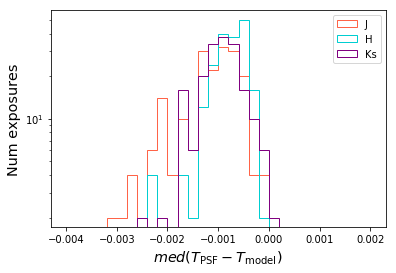

['Ks', 'H', 'J']
Ks
tomato
min and max mag:  15.9770917892 19.9384117126
[ 15.97709179  16.17515779  16.37322378  16.57128978  16.76935577
  16.96742177  17.16548777  17.36355376  17.56161976  17.75968575
  17.95775175  18.15581775  18.35388374  18.55194974  18.75001574
  18.94808173  19.14614773  19.34421372  19.54227972  19.74034572
  19.93841171]
here
[ 16.17515779  16.37322378  16.57128978  16.76935577  16.96742177
  17.16548777  17.36355376  17.56161976  17.75968575  17.95775175
  18.15581775  18.35388374  18.55194974  18.75001574  18.94808173
  19.14614773  19.34421372  19.54227972  19.74034572  19.93841171]
median  -0.00342264450297
21 20 21
H
darkturquoise
min and max mag:  15.9662284851 19.916223526
[ 15.96622849  16.16372824  16.36122799  16.55872774  16.75622749
  16.95372725  17.151227    17.34872675  17.5462265   17.74372625
  17.94122601  18.13872576  18.33622551  18.53372526  18.73122501
  18.92872477  19.12622452  19.32372427  19.52122402  19.71872377
  19.91622353]
her

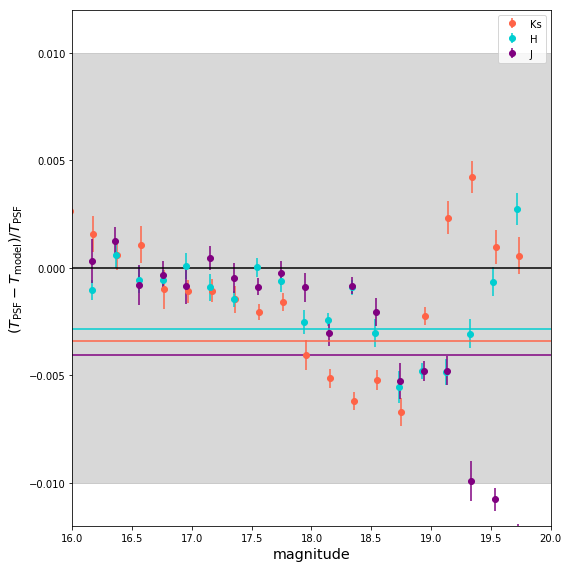

In [106]:
print('All mean dt = ',np.mean(df['fracsizeres']))
print('All median dt = ',np.median(df['fracsizeres']))
'''
# Plotting the distribution of residuals                                                                                 
plt.hist(df['sizeres'], 300,range=(0,30))
plt.xlabel('T_res = PSF - obs', fontsize='x-large')
plt.ylabel('Num good objects',fontsize='x-large')
plt.title('%s'% band)
plt.yscale('log')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()

plt.hist(df['sizeres'], 30,range=(-0.02,0.03))
plt.xlabel('T_res = PSF - obs', fontsize='x-large')
plt.ylabel('Num good objects',fontsize='x-large')
plt.title('%s'% band)
plt.yscale('log')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()

# Plotting the distribution of residuals                                                                                 
plt.hist(meandt["J"], 60)
plt.xlabel('<T_res = PSF - obs>', fontsize='x-large')
plt.ylabel('Num exps',fontsize='x-large')
plt.title('%s'% band)
plt.yscale('log')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()

plt.hist(meandt["J"], 30,range=(-0.02,0.02))
plt.xlabel('<T_res = PSF - obs>', fontsize='x-large')
plt.ylabel('Num exps',fontsize='x-large')
plt.title('%s'% band)
plt.yscale('log')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()

plt.hist(meddt["J"], 60)
plt.xlabel('med(T_res = PSF - obs)', fontsize='x-large')
plt.ylabel('Num exps',fontsize='x-large')
plt.title('%s'% band)
plt.yscale('log')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()
'''
plt.hist(meddt["J"], 30,range=(-0.004,0.002),color="tomato",label="J",histtype='step')
plt.hist(meddt["H"], 30,range=(-0.004,0.002),color="darkturquoise",label="H",histtype='step')
plt.hist(meddt["Ks"], 30,range=(-0.004,0.002),color="purple",label="Ks",histtype='step')
plt.xlabel(r'$ med(T_{\rm PSF} - T_{\rm model})$', fontsize='x-large')
plt.ylabel('Num exposures',fontsize='x-large')
#plt.title('%s'% band)
plt.yscale('log')
plt.legend()
plt.savefig('UltraVISTA_all_medresid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()

'''
fig, ax = plt.subplots()
hb=ax.hexbin(df['mag_aper'],df['sizeres'] ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.ylim(0,0.2)
plt.xlabel('%s mag_aper' %(band), fontsize='x-large')
plt.ylabel('T_res', fontsize='x-large')
plt.show()
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
'''

#subset=randomly_cull(df,80)
#keep=randomly_cull(df,percenttocut)
#stickplot(df['ra'],df['dec'], e1res, e2res, sizeres, fracsizeres, 1, 'no', 'no', 'no',0.03)
##print("done")
#med, mag_bins, bin_dtfrac,bin_dT_fracerr=bin_by_mag(df['mag_aper'], df['sizeres'], df['fracsizeres'], 15., band, name)

fig, axes = plt.subplots()   
plt.ylim(-0.012,0.012)
#plt.plot([min_mused,min_mused],[-1,1], color='Grey')
#plt.plot([19,19],[-1,1], color='Grey')
plt.fill( [16.,16.,20,20], [0.01,-0.01,-0.01,0.01], fill=True, color='grey',alpha=0.3)
#ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
print(bands)
colour=["tomato","darkturquoise","purple"]
i=0
for band in bands:
    print(band)
    df=frames['%s'%band]
    #print(df.columns)
    print(colour[i])
    med, mag_bins, bin_dTfrac,bin_dTfrac_err=bin_by_mag(df['mag_aper'], df['sizeres'], df['fracsizeres'], 15., band, name)
    plt.plot([16.0,20.0], [med,med], color=colour[i])
    print(len(mag_bins),len(bin_dTfrac),len(bin_dTfrac_err))
    plt.errorbar(mag_bins[:-1], bin_dTfrac, yerr=bin_dTfrac_err[:-1], color=colour[i], fmt='o',label=band)
    i=i+1
plt.plot([16,20], [0,0], color='black')
plt.legend() #[t_line], [r'$\delta T$'])
plt.ylabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='x-large')
plt.xlim(16.0,20.0)
plt.xlabel('magnitude', fontsize='x-large')
fig.set_size_inches(8.0,8.0)
plt.tight_layout()
name='dpsf_UVista_all_DEEP.png' 
plt.savefig(name)
plt.show()

In [11]:
#VIDEO

cdir= '/global/cscratch1/sd/amichoi/VIDEO' 
cdir2= '/global/cscratch1/sd/amichoi/VIDEO/XMM'  
        
import warnings
import os
#band="J"
bands=["J","H"]
i=0
#frame=['dfj','dfh','dfk']

meandt={}
meddt={}
frames = {}
for band in bands:
    if band=="Ks":
        num=10
    else: 
        num=9  
    print(num)
    
    thismeandt=[]
    thismeddt=[]
    
    string="VIDEO_%s_" % (band)
    for fname in os.listdir(cdir2+'/psf'):
        if fname.startswith(string) and fname.endswith('psfcat.psf'): 
            print(fname)

            name, tmp = fname.split('_psfcat.psf', 1)
            #print(name)
            #print(string2)
            #nam, tmp = string2.split('.cleaned.fits', 1)
            ##print(nam)
            #name=string+nam

            pf = '%s/psf/%s' % (cdir2, fname) # PSFEx image
            #print(pf)
            sf= '%s/psf/%s_psfex-starlist.fits' % (cdir2, name) #list of stars made from Sextractor and PSFEx
            #print(sf)
            cf = '%s/cat/%s_psfcat.fits' % (cdir2, name) #the output from extractor 
            #print(cf)
            im_f = '%s/%s.cleaned.fits' % (cdir, name)  #VIDEO_H_10_34.31_-4.80.cleaned.fits
            wt_f = '%s/%s.weight.fits'%(cdir, name) 
            #get wcs and fwhm from image file
            
            dat = fits.open(sf)[2]
            FWHM = np.mean(dat.data['FWHM_PSF']) #now Uvista also doesn't have fwhm in image header! 
            #print('FWHM: ', FWHM)

            full_image = galsim.fits.read(im_f, hdu=0)    
            wcs = full_image.wcs
            f = fitsio.FITS(im_f)
            hdu=0
            header_list = f[hdu].read_header_list()
            header_list = [ d for d in header_list if 'CONTINUE' not in d['name'] ]
            h = fitsio.FITSHDR(header_list)
            #FWHM = h['PSF_FWHM'] # this is for UV - video doesn't have fwhm in image header! 

            magzp = 30.0
            mmlogging_level = logging.INFO
            logger = logging.getLogger('size_residual')
            # Read in some useful values, such as position                                                                           
            df = read_psfex_stars(sf, cf, logger)

            # Measure the hsm shapes on the stars in the actual image  
            #ind = df.index[df['FLAGS_PSF'] == 0]
            measure_star_shapes(
                df,im_f,wt_f, noweight=False,wcs=wcs,use_ngmix=True, fwhm=FWHM,logger=logger)
            # Measure      
            measure_psfex_shapes(
                df,pf,im_f, wt_f,noweight=False,wcs=wcs,use_ngmix=True, fwhm=FWHM, logger=logger)

            #print("All objs: ", len(df))
            df = df[df.FLAGS_PSF == 0]
            #print("Flag-good objs (PSF==0) : ", len(df))

            ####################################################
            #CUTS
            good = (df['psfex_T'].values!=-999)&(df['obs_T'].values!=-999)
            df=df[good]
            print("Good shape objs: ", len(df))
            ####################################################
            #PLOT
            def compute_res(d):
                de1 =  d['obs_e1']-d[prefix+'_e1']
                de2 =  d['obs_e2']-d[prefix+'_e2']
                dt =  (d['obs_T']-d[prefix+'_T'])
                dtfrac = dt/d['obs_T']
                #print('mean dt = ',np.mean(dt))
                #print('median dt = ',np.median(dt))

                thismeandt.append(np.mean(dt))
                thismeddt.append(np.median(dt))
                return dtfrac, dt , de1, de2

            prefix="psfex"
            fracsizeres, sizeres, e1res, e2res=compute_res(df)
            df['fracsizeres'], df['sizeres'], df['e1res'], df['e2res']  = compute_res(df)

            #print(name)        
            if i==0:
                dfold=df
                #print(len(dfold)) 
            else: # i>0:  
                dfnew=df
                df = pd.concat([dfold, dfnew])
                dfold=df
                #print(i)
                print(len(df))    
            i+=1

    print(band, len(df))
    frames[band]=df
    meandt[band]=thismeandt
    meddt[band]=thismeddt


  
'''   for filename in os.listdir(cdir4+"/psf"):
        #print(filename)
        if filename.startswith("UVISTA_%s" %band):
            if filename.endswith("_psfcat.psf"):
                #print(filename)
                named=filename[num:] #10, 9
                #print(named)
                name=named[:-11]
                #print(band, name) 
                
                if band=="Ks":
                    if name=="9_150.13_2.63":
                        print("glazing over")
                        continue
                    elif name =="1_149.40_2.54":
                        print("glazing over")
                        continue
                    elif name=="15_150.50_2.17":
                        print("glazing over")
                        continue 
'''


9
VIDEO_J_3_36.44_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_J_3_36.44_-4.09_psfex-starlist.fits
   found %d stars 2926 117524
2926 2926
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.09122178386 0.294931995289
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.928861426442 -1.1667705425
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.64516906824 5.39615878876
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.48004582787 3.66306355621
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.14568409207 6.14888918252
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.07012590075 -5.15321658908
Good shape objs:  115
VIDEO_J_6_36.80_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_J_6_36.80_-4.46_psfex-starlist.fits
   found %d stars 3561 146314
3561 3561
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.31431993721 0.117768351699
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2

 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.132405858808 -1.24356880892
Good shape objs:  81
21472
VIDEO_H_1_36.99_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_36.99_-4.27_psfex-starlist.fits
   found %d stars 2515 101240
2515 2515


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.810099037765 -0.73900527701
Good shape objs:  77
21549
VIDEO_H_1_34.03_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_34.03_-5.36_psfex-starlist.fits
   found %d stars 1690 67331
1690 1690


Good shape objs:  98
21647
VIDEO_H_15_36.44_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_36.44_-5.38_psfex-starlist.fits
   found %d stars 2325 92316
2325 2325


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.548481373 0.252467745596
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.598554467597 -1.84202965863
Good shape objs:  85
21732
VIDEO_H_14_35.57_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_35.57_-5.28_psfex-starlist.fits
   found %d stars 2641 106705
2641 2641


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.186915699145 -2.59606848349
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.1535243575 2.62553316851
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.714301016183 -0.735752965564
Good shape objs:  100
21832
VIDEO_H_6_35.57_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_35.57_-4.54_psfex-starlist.fits
   found %d stars 3316 135818
3316 3316


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.86050815043 -0.803162353061
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.44058497979 -4.12460681583
Good shape objs:  112
21944
VIDEO_H_8_34.77_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_34.77_-4.99_psfex-starlist.fits
   found %d stars 1850 74301
1850 1850


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -6.1044799485 -2.45476586007
Good shape objs:  78
22022
VIDEO_H_12_34.77_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_34.77_-4.62_psfex-starlist.fits
   found %d stars 2197 89388
2197 2197


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.08270960876 -5.90218856749
Good shape objs:  85
22107
VIDEO_H_3_35.29_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_35.29_-4.17_psfex-starlist.fits
   found %d stars 2688 110660
2688 2688


Good shape objs:  98
22205
VIDEO_H_4_36.25_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_36.25_-4.09_psfex-starlist.fits
   found %d stars 2611 104887
2611 2611


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.115445676926 6.19359325115
Good shape objs:  96
22301
VIDEO_H_16_35.20_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_35.20_-5.28_psfex-starlist.fits
   found %d stars 2660 107047
2660 2660


Good shape objs:  98
22399
VIDEO_H_13_37.08_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_37.08_-5.20_psfex-starlist.fits
   found %d stars 2635 106111
2635 2635


Good shape objs:  88
22487
VIDEO_H_11_36.44_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_36.44_-4.83_psfex-starlist.fits
   found %d stars 2550 99532
2550 2550


Good shape objs:  114
22601
VIDEO_H_3_35.39_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_35.39_-4.17_psfex-starlist.fits
   found %d stars 2952 123843
2952 2952


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.20321997694 3.85025356778
Good shape objs:  100
22701
VIDEO_H_11_35.29_-5.10_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_35.29_-5.10_psfex-starlist.fits
   found %d stars 2825 115972
2825 2825


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.66471403394 3.65079914381
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.797373061717 2.22350234497
Good shape objs:  104
22805
VIDEO_H_3_34.68_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_34.68_-5.54_psfex-starlist.fits
   found %d stars 1738 71223
1738 1738


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.51677243465 9.50369246787
Good shape objs:  76
22881
VIDEO_H_8_36.07_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_36.07_-4.64_psfex-starlist.fits
   found %d stars 2577 103071
2577 2577


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.4576422905 -3.45370839012
Good shape objs:  88
22969
VIDEO_H_15_36.34_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_36.34_-5.20_psfex-starlist.fits
   found %d stars 2811 113719
2811 2811


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.74226411135 -2.88800651777
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.76996975471 1.6153871779
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.29420264359 -3.93096955852
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.55300963125 -4.45243778505
Good shape objs:  92
23061
VIDEO_H_8_34.86_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_34.86_-5.17_psfex-starlist.fits
   found %d stars 1927 75209
1927 1927


Good shape objs:  91
23152
VIDEO_H_1_34.13_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_34.13_-5.54_psfex-starlist.fits
   found %d stars 1550 60164
1550 1550


Good shape objs:  84
23236
VIDEO_H_5_37.08_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_37.08_-4.46_psfex-starlist.fits
   found %d stars 2822 113092
2822 2822


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.828492629622 -1.33033684201
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.591189039515 1.76030254893
Good shape objs:  91
23327
VIDEO_H_15_34.68_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_34.68_-4.25_psfex-starlist.fits
   found %d stars 1928 76334
1928 1928


Good shape objs:  86
23413
VIDEO_H_1_35.85_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_35.85_-4.36_psfex-starlist.fits
   found %d stars 3029 122584
3029 3029


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.14542750719 -1.3344615143
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.46238227584 0.403194288399
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.674033765965 1.81268695661
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.1339564304 -2.99533248023
Good shape objs:  116
23529
VIDEO_H_1_33.94_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_33.94_-5.54_psfex-starlist.fits
   found %d stars 1681 65508
1681 1681


Good shape objs:  92
23621
VIDEO_H_9_35.94_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_35.94_-4.91_psfex-starlist.fits
   found %d stars 3014 121896
3014 3014


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.97127420379 -2.22573095408
Good shape objs:  98
23719
VIDEO_H_12_34.86_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_34.86_-4.62_psfex-starlist.fits
   found %d stars 2354 95495
2354 2354


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.19007669694 0.366668029358
Good shape objs:  79
23798
VIDEO_H_3_35.29_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_35.29_-4.36_psfex-starlist.fits
   found %d stars 2871 117251
2871 2871


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.81114106956 0.726309530552
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.08811077402 -3.90319606532
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.36684565189 1.38477358968
Good shape objs:  112
23910
VIDEO_H_14_36.62_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_36.62_-5.38_psfex-starlist.fits
   found %d stars 2466 97929
2466 2466


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.09502096783 2.54004495534
Good shape objs:  95
24005
VIDEO_H_1_34.03_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_34.03_-5.54_psfex-starlist.fits
   found %d stars 1590 62073
1590 1590


Good shape objs:  97
24102
VIDEO_H_8_34.86_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_34.86_-4.99_psfex-starlist.fits
   found %d stars 1872 75073
1872 1872


Good shape objs:  73
24175
VIDEO_H_4_36.07_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_36.07_-4.09_psfex-starlist.fits
   found %d stars 2588 102885
2588 2588


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.38748592556 4.82720777947
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.36611764037 -4.95032818028
Good shape objs:  71
24246
VIDEO_H_3_35.48_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_35.48_-4.36_psfex-starlist.fits
   found %d stars 2920 122403
2920 2920


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.3712798424 -0.950940313594
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.23771002093 3.12657678007
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.872401205381 -0.496050116472
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -6.05396144902 2.39760774339
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.33681960291 -5.1737378871
Good shape objs:  93
24339
VIDEO_H_12_34.96_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_34.96_-4.80_psfex-starlist.fits
   found %d stars 2047 82878
2047 2047


Good shape objs:  88
24427
VIDEO_H_15_34.68_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_34.68_-4.44_psfex-starlist.fits
   found %d stars 1736 68361
1736 1736


Good shape objs:  62
24489
VIDEO_H_12_36.07_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_36.07_-5.01_psfex-starlist.fits
   found %d stars 2877 114819
2877 2877


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.85725013981 -2.56798933525
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -9.52493147365 4.68287889816
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.47612362674 -3.42571138805
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.907423823723 4.14721703284
Good shape objs:  94
24583
VIDEO_H_16_34.77_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_34.77_-4.25_psfex-starlist.fits
   found %d stars 1815 72690
1815 1815


Good shape objs:  72
24655
VIDEO_H_6_34.40_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_34.40_-5.17_psfex-starlist.fits
   found %d stars 1885 73905
1885 1885


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.14621374209 1.3538903811
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.12725644353 1.4049540712
Good shape objs:  84
24739
VIDEO_H_12_35.11_-5.10_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_35.11_-5.10_psfex-starlist.fits
   found %d stars 2852 117260
2852 2852


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.571331223568 -4.96970154178
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.865933171583 5.28152626639
Good shape objs:  112
24851
VIDEO_H_6_34.22_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_34.22_-4.99_psfex-starlist.fits
   found %d stars 2041 81078
2041 2041


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.27120334301 3.59734910593
Good shape objs:  89
24940
VIDEO_H_2_34.40_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_34.40_-5.36_psfex-starlist.fits
   found %d stars 1860 74857
1860 1860


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.72882557344 4.49915624701
Good shape objs:  82
25022
VIDEO_H_13_36.90_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_36.90_-5.38_psfex-starlist.fits
   found %d stars 2467 99417
2467 2467


Good shape objs:  80
25102
VIDEO_H_7_34.59_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_34.59_-5.17_psfex-starlist.fits
   found %d stars 1801 70543
1801 1801


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 11.7560552071 -1.17858735259
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.69220180695 -5.95970747004
Good shape objs:  95
25197
VIDEO_H_13_34.12_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_34.12_-4.44_psfex-starlist.fits
   found %d stars 1868 73281
1868 1868


Good shape objs:  84
25281
VIDEO_H_14_36.81_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_36.81_-5.38_psfex-starlist.fits
   found %d stars 2734 108537
2734 2734


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.07976664974 4.22858773879
Good shape objs:  94
25375
VIDEO_H_10_34.40_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_34.40_-4.62_psfex-starlist.fits
   found %d stars 2243 91998
2243 2243


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.86090287113 -5.89109129606
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.37750675528 0.756805524081
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.827107107583 5.58719984148
Good shape objs:  103
25478
VIDEO_H_7_35.48_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_35.48_-4.54_psfex-starlist.fits
   found %d stars 3406 139883
3406 3406


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.13502575455 -0.81306419914
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.708434372785 -5.48140062668
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.63872817598 2.53994640869
Good shape objs:  116
25594
VIDEO_H_5_34.13_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_34.13_-5.17_psfex-starlist.fits
   found %d stars 1680 66287
1680 1680


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.89405856051 1.42425066867
Good shape objs:  86
25680
VIDEO_H_7_36.44_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_36.44_-4.64_psfex-starlist.fits
   found %d stars 2590 102810
2590 2590


Good shape objs:  107
25787
VIDEO_H_12_35.02_-5.10_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_35.02_-5.10_psfex-starlist.fits
   found %d stars 3001 123928
3001 3001


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.970771545552 4.91191575574
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.314062067849 -5.42682156993
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.599515126522 5.53539404781
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 8.24278180399 -3.46602943898
Good shape objs:  121
25908
VIDEO_H_11_34.68_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_34.68_-4.62_psfex-starlist.fits
   found %d stars 2018 82286
2018 2018


Good shape objs:  81
25989
VIDEO_H_15_34.59_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_34.59_-4.44_psfex-starlist.fits
   found %d stars 1726 68471
1726 1726


Good shape objs:  84
26073
VIDEO_H_7_34.68_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_34.68_-5.17_psfex-starlist.fits
   found %d stars 1792 69505
1792 1792


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.974282789131 0.849686571747
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.09906299029 -1.72605880129
Good shape objs:  80
26153
VIDEO_H_11_34.49_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_34.49_-4.62_psfex-starlist.fits
   found %d stars 2092 85224
2092 2092


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.93736413087 1.12185539633
Good shape objs:  88
26241
VIDEO_H_16_35.11_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_35.11_-5.28_psfex-starlist.fits
   found %d stars 2733 112052
2733 2733


Good shape objs:  97
26338
VIDEO_H_3_34.50_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_34.50_-5.36_psfex-starlist.fits
   found %d stars 1669 66915
1669 1669


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.04118822016 0.387962357202
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.69854981157 -3.13056680871
Good shape objs:  79
26417
VIDEO_H_1_35.85_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_35.85_-4.17_psfex-starlist.fits
   found %d stars 2796 112703
2796 2796


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.97980914757 7.25103439825
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 11.5256339593 -3.36803436047
Good shape objs:  94
26511
VIDEO_H_14_35.75_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_35.75_-5.28_psfex-starlist.fits
   found %d stars 2596 104422
2596 2596


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.62997747956 1.22931176983
Good shape objs:  99
26610
VIDEO_H_2_36.80_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_36.80_-4.27_psfex-starlist.fits
   found %d stars 2689 108695
2689 2689


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.66661932727 -0.761118010275
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.28265811214 0.919551406562
Good shape objs:  89
26699
VIDEO_H_3_36.44_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_36.44_-4.09_psfex-starlist.fits
   found %d stars 2713 109525
2713 2713


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.77968844632 -1.45478113543
Good shape objs:  93
26792
VIDEO_H_7_36.34_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_36.34_-4.64_psfex-starlist.fits
   found %d stars 2639 103885
2639 2639


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.71011303518 -1.47939199507
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.26344790566 -1.82155541427
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.22231054405 2.09706013172
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.9951608009 -1.78664490279
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.0171608391583 1.38931825537
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.19023691892 3.39651005585
Good shape objs:  119
26911
VIDEO_H_2_34.31_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_34.31_-5.36_psfex-starlist.fits
   found %d stars 1732 70115
1732 1732


Good shape objs:  71
26982
VIDEO_H_3_34.59_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_34.59_-5.36_psfex-starlist.fits
   found %d stars 1861 75085
1861 1861


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.31072973084 0.394233076905
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.47176884549 1.0030574935
Good shape objs:  80
27062
VIDEO_H_13_33.94_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_33.94_-4.25_psfex-starlist.fits
   found %d stars 1658 67892
1658 1658


Good shape objs:  50
27112
VIDEO_H_11_36.53_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_36.53_-4.83_psfex-starlist.fits
   found %d stars 2804 112098
2804 2804


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.07891241258 -2.11189531699
Good shape objs:  106
27218
VIDEO_H_13_34.12_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_34.12_-4.25_psfex-starlist.fits
   found %d stars 1916 77537
1916 1916


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.04508284422 4.06844889771
Good shape objs:  82
27300
VIDEO_H_8_36.07_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_36.07_-4.46_psfex-starlist.fits
   found %d stars 2527 99156
2527 2527


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.38887106253 0.640470880289
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.39458187048 2.39188494923
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.938368395241 -5.74831022055
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.79873741609 -2.65960766521
Good shape objs:  102
27402
VIDEO_H_4_34.77_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_34.77_-5.54_psfex-starlist.fits
   found %d stars 1819 73080
1819 1819


Good shape objs:  73
27475
VIDEO_H_16_35.02_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_35.02_-5.28_psfex-starlist.fits
   found %d stars 2479 101523
2479 2479


Good shape objs:  92
27567
VIDEO_H_8_34.96_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_34.96_-5.17_psfex-starlist.fits
   found %d stars 1879 75169
1879 1879


Good shape objs:  87
27654
VIDEO_H_2_34.40_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_34.40_-5.54_psfex-starlist.fits
   found %d stars 1666 65838
1666 1666


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.75327302096 -0.802991538038
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.05125346687 1.31851057239
Good shape objs:  82
27736
VIDEO_H_16_36.25_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_36.25_-5.20_psfex-starlist.fits
   found %d stars 2428 99435
2428 2428


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.01189184294 -4.28254296653
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.73929091 -2.88416805801
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.29106224166 -4.18612001342
Good shape objs:  84
27820
VIDEO_H_2_35.66_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_35.66_-4.36_psfex-starlist.fits
   found %d stars 2409 103320
2409 2409


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.429329411262 -1.81694730965
Good shape objs:  87
27907
VIDEO_H_9_37.08_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_37.08_-5.01_psfex-starlist.fits
   found %d stars 2546 101124
2546 2546


Good shape objs:  89
27996
VIDEO_H_3_36.44_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_36.44_-4.27_psfex-starlist.fits
   found %d stars 2484 97985
2484 2484


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.73415604696 -6.2777110317
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.89025938571 -1.62177626062
Good shape objs:  91
28087
VIDEO_H_9_36.90_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_36.90_-4.83_psfex-starlist.fits
   found %d stars 2766 111174
2766 2766


Good shape objs:  81
28168
VIDEO_H_15_36.53_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_36.53_-5.38_psfex-starlist.fits
   found %d stars 2362 93572
2362 2362


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.10099019018 2.85487464482
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.62593183408 0.262322703205
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.347942829374 -1.85517997966
Good shape objs:  106
28274
VIDEO_H_4_36.07_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_36.07_-4.27_psfex-starlist.fits
   found %d stars 2627 106606
2627 2627


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.1398594261 5.45154984236
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.757459882919 1.20007186816
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.83298580544 10.0931870204
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.796486423624 0.665077653207
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.79355018718 -1.22628766818
Good shape objs:  88
28362
VIDEO_H_1_37.08_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_37.08_-4.09_psfex-starlist.fits
   found %d stars 2626 103948
2626 2626


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.5238502909 0.491923838588
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.751008380361 -2.96527477743
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.53468545402 6.09902785637
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.1356671004 2.2612648479
Good shape objs:  104
28466
VIDEO_H_9_35.94_-5.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_35.94_-5.09_psfex-starlist.fits
   found %d stars 2837 117230
2837 2837


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.762411383466 5.01097898875
Good shape objs:  93
28559
VIDEO_H_7_36.53_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_36.53_-4.64_psfex-starlist.fits
   found %d stars 2622 104657
2622 2622


Good shape objs:  105
28664
VIDEO_H_7_35.48_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_35.48_-4.73_psfex-starlist.fits
   found %d stars 3146 129842
3146 3146


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.04263389492 5.0312529827
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.867874297505 -0.571280778362
Good shape objs:  101
28765
VIDEO_H_14_35.57_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_35.57_-5.46_psfex-starlist.fits
   found %d stars 2885 119715
2885 2885


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.15079807542 -4.16779149533
Good shape objs:  79
28844
VIDEO_H_16_34.95_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_34.95_-4.44_psfex-starlist.fits
   found %d stars 1853 76100
1853 1853


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.68583788003 4.09840135134
Good shape objs:  65
28909
VIDEO_H_1_36.03_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_36.03_-4.17_psfex-starlist.fits
   found %d stars 3080 126880
3080 3080


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.86117162645 6.03489552076
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.87296368326 -1.30007200292
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.41307754931 4.8210902416
Good shape objs:  104
29013
VIDEO_H_14_35.66_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_35.66_-5.46_psfex-starlist.fits
   found %d stars 2808 114419
2808 2808


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.5876173659 1.76676974387
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.22442180285 -0.780318908836
Good shape objs:  99
29112
VIDEO_H_5_33.94_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_33.94_-4.99_psfex-starlist.fits
   found %d stars 1879 77168
1879 1879


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.345631180912 1.10633268649
Good shape objs:  88
29200
VIDEO_H_16_36.16_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_36.16_-5.20_psfex-starlist.fits
   found %d stars 2484 99450
2484 2484


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.00600295313 -4.01082241703
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.61041148532 6.18483977547
Good shape objs:  83
29283
VIDEO_H_12_36.16_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_36.16_-5.01_psfex-starlist.fits
   found %d stars 2948 116985
2948 2948


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.4908225428 3.68260975856
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.13915794353 0.202890569131
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.46920325899 -2.57244833529
Good shape objs:  88
29371
VIDEO_H_10_34.22_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_34.22_-4.80_psfex-starlist.fits
   found %d stars 1806 73646
1806 1806


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.83455603602 -6.70779025153
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.88388523082 4.80154071341
Good shape objs:  78
29449
VIDEO_H_1_36.03_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_36.03_-4.36_psfex-starlist.fits
   found %d stars 2794 114841
2794 2794


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.89430084684 3.92388934967
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.19710660927 -5.74676086522
Good shape objs:  88
29537
VIDEO_H_5_36.03_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_36.03_-4.54_psfex-starlist.fits
   found %d stars 3059 124485
3059 3059


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.50229331314 0.653083777751
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.252793100887 1.35552840129
Good shape objs:  100
29637
VIDEO_H_9_35.85_-5.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_35.85_-5.09_psfex-starlist.fits
   found %d stars 2619 105755
2619 2619


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.5050974072 -9.76997971207
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.37877058748 4.4274157218
Good shape objs:  109
29746
VIDEO_H_2_36.62_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_36.62_-4.27_psfex-starlist.fits
   found %d stars 2365 95051
2365 2365


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.412964114458 -1.0479421263
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.99062937551 0.713713241279
Good shape objs:  83
29829
VIDEO_H_2_34.22_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_34.22_-5.36_psfex-starlist.fits
   found %d stars 1526 61605
1526 1526


Good shape objs:  72
29901
VIDEO_H_5_35.85_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_35.85_-4.73_psfex-starlist.fits
   found %d stars 2755 111880
2755 2755


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.97798140932 -5.43995385112
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.32597345827 -4.21887378007
Good shape objs:  99
30000
VIDEO_H_14_35.66_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_35.66_-5.28_psfex-starlist.fits
   found %d stars 2698 108817
2698 2698


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.31038502439 1.4706352975
Good shape objs:  111
30111
VIDEO_H_14_36.62_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_36.62_-5.20_psfex-starlist.fits
   found %d stars 2734 109993
2734 2734


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.17751084395 12.2849763069
Good shape objs:  91
30202
VIDEO_H_5_36.99_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_36.99_-4.64_psfex-starlist.fits
   found %d stars 2378 95015
2378 2378


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.16621545202 -5.94530202808
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.34029558871 -2.21959304441
Good shape objs:  88
30290
VIDEO_H_13_35.94_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_35.94_-5.46_psfex-starlist.fits
   found %d stars 2389 100449
2389 2389


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 7.5818600221 -0.394253297271
Good shape objs:  72
30362
VIDEO_H_6_36.62_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_36.62_-4.64_psfex-starlist.fits
   found %d stars 2712 107076
2712 2712


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.15913691071 3.19683383102
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.422082275293 10.7394208119
Good shape objs:  101
30463
VIDEO_H_14_34.40_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_34.40_-4.25_psfex-starlist.fits
   found %d stars 2104 83856
2104 2104


Good shape objs:  82
30545
VIDEO_H_6_35.66_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_35.66_-4.73_psfex-starlist.fits
   found %d stars 3172 129730
3172 3172


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.7695807457 -5.64516511583
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 9.61614731872 2.10169197582
Good shape objs:  95
30640
VIDEO_H_11_35.29_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_35.29_-4.91_psfex-starlist.fits
   found %d stars 2954 120560
2954 2954


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.91124887275 -1.89775592953
Good shape objs:  116
30756
VIDEO_H_8_34.96_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_34.96_-4.99_psfex-starlist.fits
   found %d stars 1865 75198
1865 1865


Good shape objs:  65
30821
VIDEO_H_16_34.77_-4.43_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_34.77_-4.43_psfex-starlist.fits
   found %d stars 1938 77991
1938 1938


Good shape objs:  62
30883
VIDEO_H_7_34.49_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_34.49_-4.99_psfex-starlist.fits
   found %d stars 2110 84382
2110 2110


Good shape objs:  82
30965
VIDEO_H_9_34.12_-4.81_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_34.12_-4.81_psfex-starlist.fits
   found %d stars 1762 71351
1762 1762


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.91574811435 0.455389409626
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.12568216807 4.21889621595
Good shape objs:  79
31044
VIDEO_H_9_36.99_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_36.99_-5.01_psfex-starlist.fits
   found %d stars 2457 99028
2457 2457


Good shape objs:  86
31130
VIDEO_H_2_35.57_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_35.57_-4.36_psfex-starlist.fits
   found %d stars 2705 117405
2705 2705


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 10.9875934362 -17.7678631107
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.027921670194 1.23065767783
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.79563536236 -11.3898402746
Good shape objs:  75
31205
VIDEO_H_13_34.03_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_34.03_-4.25_psfex-starlist.fits
   found %d stars 1943 78502
1943 1943


Good shape objs:  82
31287
VIDEO_H_8_36.16_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_36.16_-4.64_psfex-starlist.fits
   found %d stars 2451 96887
2451 2451


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -11.2688122978 2.34518960523
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.21489149526 0.335104620703
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.34167900148 -0.125104334042
Good shape objs:  96
31383
VIDEO_H_16_36.07_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_36.07_-5.20_psfex-starlist.fits
   found %d stars 2495 100543
2495 2495


Good shape objs:  79
31462
VIDEO_H_5_36.03_-4.72_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_36.03_-4.72_psfex-starlist.fits
   found %d stars 3071 125579
3071 3071


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.29212843341 0.479156421964
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.562715492338 -0.840368502466
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.712294732771 -3.524245821
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.45723399537 -3.45219542955
Good shape objs:  98
31560
VIDEO_H_12_35.11_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_35.11_-4.91_psfex-starlist.fits
   found %d stars 3179 132432
3179 3179


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.27716889691 -4.16543901016
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.79764231417 2.61821747981
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.630327388696 6.16827070478
Good shape objs:  110
31670
VIDEO_H_7_35.39_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_35.39_-4.73_psfex-starlist.fits
   found %d stars 3090 127725
3090 3090


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.49087494536 4.0306384407
Good shape objs:  120
31790
VIDEO_H_11_34.59_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_34.59_-4.80_psfex-starlist.fits
   found %d stars 1911 76741
1911 1911


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.685205036766 -1.15942348586
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.33445086481 4.01656843674
Good shape objs:  67
31857
VIDEO_H_2_36.80_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_36.80_-4.09_psfex-starlist.fits
   found %d stars 2663 106110
2663 2663


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.666447601924 -6.43642005102
Good shape objs:  97
31954
VIDEO_H_3_34.68_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_34.68_-5.36_psfex-starlist.fits
   found %d stars 1815 72207
1815 1815


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.19596992003 1.2578952196
Good shape objs:  81
32035
VIDEO_H_9_33.94_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_33.94_-4.80_psfex-starlist.fits
   found %d stars 2013 80573
2013 2013


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.34860110388 -1.90358555679
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.01326683 -4.09781465242
Good shape objs:  77
32112
VIDEO_H_3_36.53_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_36.53_-4.27_psfex-starlist.fits
   found %d stars 2234 90182
2234 2234


Good shape objs:  93
32205
VIDEO_H_4_34.96_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_34.96_-5.36_psfex-starlist.fits
   found %d stars 1768 70899
1768 1768


Good shape objs:  68
32273
VIDEO_H_10_36.81_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_36.81_-4.83_psfex-starlist.fits
   found %d stars 2771 112845
2771 2771


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.16923553235 0.565289953876
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.00050953484 1.02662003014
Good shape objs:  88
32361
VIDEO_H_9_34.03_-4.81_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_34.03_-4.81_psfex-starlist.fits
   found %d stars 2036 82261
2036 2036


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.12507776298 4.22199060583
Good shape objs:  76
32437
VIDEO_H_7_36.44_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_36.44_-4.46_psfex-starlist.fits
   found %d stars 3097 123684
3097 3097


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.16424984914 0.361896640574
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.997861442306 -0.253219391815
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.65064285895 -0.26238629229
Good shape objs:  104
32541
VIDEO_H_13_35.94_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_35.94_-5.28_psfex-starlist.fits
   found %d stars 2610 107047
2610 2610


Good shape objs:  96
32637
VIDEO_H_5_35.94_-4.72_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_35.94_-4.72_psfex-starlist.fits
   found %d stars 2783 113113
2783 2783


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.54146363583 0.472062383263
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.951026220774 -3.44744598995
Good shape objs:  97
32734
VIDEO_H_12_36.25_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_36.25_-4.83_psfex-starlist.fits
   found %d stars 2990 118919
2990 2990


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.46891646794 -0.392839623756
Good shape objs:  104
32838
VIDEO_H_10_36.71_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_36.71_-5.01_psfex-starlist.fits
   found %d stars 3102 128359
3102 3102


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.553590215276 -9.5358464022
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 11.1808420227 0.669945231992
Good shape objs:  84
32922
VIDEO_H_15_36.34_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_36.34_-5.38_psfex-starlist.fits
   found %d stars 2319 92086
2319 2319


Good shape objs:  78
33000
VIDEO_H_10_35.66_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_35.66_-4.91_psfex-starlist.fits
   found %d stars 2995 124054
2995 2995


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.0909676261706 1.11543981117
Good shape objs:  83
33083
VIDEO_H_7_36.53_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_36.53_-4.46_psfex-starlist.fits
   found %d stars 2988 120543
2988 2988


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.12397671182 1.41366259131
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.15869539389 2.98692210421
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.07071122969 -1.02646054115
Good shape objs:  109
33192
VIDEO_H_7_35.29_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_35.29_-4.73_psfex-starlist.fits
   found %d stars 3184 132560
3184 3184


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 9.97402168092 -3.70317106046
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.75846027924 4.023960069
Good shape objs:  118
33310
VIDEO_H_5_36.99_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_36.99_-4.46_psfex-starlist.fits
   found %d stars 2819 111542
2819 2819


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.501481843778 -1.26332383359
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.40501676397 1.42707786622
Good shape objs:  94
33404
VIDEO_H_3_36.53_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_36.53_-4.09_psfex-starlist.fits
   found %d stars 2779 111118
2779 2779


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.65087426342 0.195055747126
Good shape objs:  98
33502
VIDEO_H_1_34.13_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_34.13_-5.36_psfex-starlist.fits
   found %d stars 1573 63022
1573 1573


Good shape objs:  81
33583
VIDEO_H_12_35.20_-5.10_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_35.20_-5.10_psfex-starlist.fits
   found %d stars 2956 120155
2956 2956


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.29626826311 -0.210597621219
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.53182092967 -5.64653482922
Good shape objs:  101
33684
VIDEO_H_10_36.62_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_36.62_-4.83_psfex-starlist.fits
   found %d stars 2809 111552
2809 2809


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.30401188119 -2.7411464052
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.93363585054 -1.74779558997
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.03818284837 1.43957000081
Good shape objs:  116
33800
VIDEO_H_5_34.03_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_34.03_-4.99_psfex-starlist.fits
   found %d stars 2122 86547
2122 2122


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.30778701568 -0.591104134367
Good shape objs:  83
33883
VIDEO_H_1_36.99_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_36.99_-4.09_psfex-starlist.fits
   found %d stars 2516 98390
2516 2516


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.83356672499 0.60735879273
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.93650886092 -3.54574956982
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.08260341987 -4.99642150199
Good shape objs:  118
34001
VIDEO_H_4_36.25_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_36.25_-4.27_psfex-starlist.fits
   found %d stars 2726 113437
2726 2726


Good shape objs:  64
34065
VIDEO_H_16_34.86_-4.43_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_34.86_-4.43_psfex-starlist.fits
   found %d stars 1985 81747
1985 1985


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.917577106285 -11.2577027777
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.05137039539 5.73306241114
Good shape objs:  78
34143
VIDEO_H_8_34.77_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_34.77_-5.17_psfex-starlist.fits
   found %d stars 1884 74657
1884 1884


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.17955792223 0.819218347034
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.64249878011 -1.79094928052
Good shape objs:  75
34218
VIDEO_H_12_35.02_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_35.02_-4.91_psfex-starlist.fits
   found %d stars 3095 126482
3095 3095


Good shape objs:  113
34331
VIDEO_H_14_36.71_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_36.71_-5.38_psfex-starlist.fits
   found %d stars 2554 100789
2554 2554


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.9026957186 -0.20255734431
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.81756427226 4.49369489854
Good shape objs:  98
34429
VIDEO_H_16_36.07_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_36.07_-5.38_psfex-starlist.fits
   found %d stars 2250 88131
2250 2250


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.32724155714 -3.30521997906
Good shape objs:  78
34507
VIDEO_H_12_35.20_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_35.20_-4.91_psfex-starlist.fits
   found %d stars 3160 129711
3160 3160


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.88661169545 -2.17323135426
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.72316789781 4.07802100159
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.06385821375 -0.773590576248
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.78627959238 2.61603978184
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.0552355921878 4.11430701441
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.17391984405 4.76964427143
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 8.5583366731 2.00284607662
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.43194823124 -1.82035522459
Good shape objs:  109
34616
VIDEO_H_11_35.48_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_35.48_-4.91_psfex-starlist.fits
   found %d stars 2917 122139
2917 2917


Good shape objs:  86
34702
VIDEO_H_8_35.02_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_35.02_-4.54_psfex-starlist.fits
   found %d stars 2925 119826
2925 2925


     bad covariance matrix
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -6.75782733039 -1.41433666619
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.0899276937998 -3.15932608715
Good shape objs:  96
34798
VIDEO_H_6_35.75_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_35.75_-4.54_psfex-starlist.fits
   found %d stars 3452 143333
3452 3452


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.77995525278 2.81810602461
Good shape objs:  96
34894
VIDEO_H_4_34.86_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_34.86_-5.36_psfex-starlist.fits
   found %d stars 1852 75772
1852 1852


Good shape objs:  73
34967
VIDEO_H_15_34.59_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_34.59_-4.25_psfex-starlist.fits
   found %d stars 1794 71582
1794 1794


Good shape objs:  96
35063
VIDEO_H_15_35.39_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_35.39_-5.28_psfex-starlist.fits
   found %d stars 2831 115813
2831 2831


Good shape objs:  93
35156
VIDEO_H_15_34.49_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_34.49_-4.25_psfex-starlist.fits
   found %d stars 1846 76204
1846 1846


Good shape objs:  77
35233
VIDEO_H_14_35.75_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_35.75_-5.46_psfex-starlist.fits
   found %d stars 2644 107168
2644 2644


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.14934430236 -4.4334899436
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.62673202655 1.53545435551
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.912879645891 -0.481053831314
Good shape objs:  113
35346
VIDEO_H_2_36.71_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_36.71_-4.09_psfex-starlist.fits
   found %d stars 2739 108947
2739 2739


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.2822124436 0.369054745462
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.658390239131 -6.44759089178
Good shape objs:  104
35450
VIDEO_H_15_35.29_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_35.29_-5.28_psfex-starlist.fits
   found %d stars 2733 110528
2733 2733


Good shape objs:  102
35552
VIDEO_H_4_35.20_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_35.20_-4.17_psfex-starlist.fits
   found %d stars 2635 108491
2635 2635


Good shape objs:  108
35660
VIDEO_H_16_34.95_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_34.95_-4.25_psfex-starlist.fits
   found %d stars 1802 71958
1802 1802


Good shape objs:  76
35736
VIDEO_H_6_36.71_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_36.71_-4.64_psfex-starlist.fits
   found %d stars 2703 108133
2703 2703


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.866537382213 -0.609680215441
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.90304765632 3.20047001232
Good shape objs:  97
35833
VIDEO_H_9_36.03_-5.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_36.03_-5.09_psfex-starlist.fits
   found %d stars 2905 119148
2905 2905


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.42197160258 -2.82143598397
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.56765847674 4.76833046683
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.973058283113 4.75106856084
Good shape objs:  85
35918
VIDEO_H_11_34.68_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_34.68_-4.80_psfex-starlist.fits
   found %d stars 1661 66504
1661 1661


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.684677112107 -1.18319482367
Good shape objs:  67
35985
VIDEO_H_13_36.90_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_36.90_-5.20_psfex-starlist.fits
   found %d stars 2501 100657
2501 2501


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.96426200183 -1.44688675799
Good shape objs:  81
36066
VIDEO_H_11_36.34_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_36.34_-5.01_psfex-starlist.fits
   found %d stars 2596 103498
2596 2596


Good shape objs:  111
36177
VIDEO_H_3_35.39_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_35.39_-4.36_psfex-starlist.fits
   found %d stars 2817 117288
2817 2817


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.76559055143 0.127388546493
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.49700423687 0.703013901493
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.86824226323 4.31182241521
Good shape objs:  115
36292
VIDEO_H_10_34.31_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_34.31_-4.62_psfex-starlist.fits
   found %d stars 2139 86329
2139 2139


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.59593009798 -0.407374600626
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.12289205494 -5.63039984099
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.799831739826 5.57997146295
Good shape objs:  89
36381
VIDEO_H_7_35.29_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_35.29_-4.54_psfex-starlist.fits
   found %d stars 3410 143436
3410 3410


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.64878017894 -5.02842539296
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.772076481185 -0.934470032206
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.00319413984 0.398361259738
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.89162703182 -1.30620621926
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.344581164936 -1.26975844913
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.431112193309 2.14940363125
Good shape objs:  108
36489
VIDEO_H_3_36.34_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_36.34_-4.27_psfex-starlist.fits
   found %d stars 2674 109058
2674 2674


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.99162384096 -6.27424928748
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.60645342522 -1.60005657669
Good shape objs:  71
36560
VIDEO_H_10_34.31_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_34.31_-4.80_psfex-starlist.fits
   found %d stars 1846 73745
1846 1846


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.14345919127 4.5386014546
Good shape objs:  80
36640
VIDEO_H_13_35.85_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_35.85_-5.46_psfex-starlist.fits
   found %d stars 2288 91005
2288 2288


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.76636131876 -1.87261931142
Good shape objs:  92
36732
VIDEO_H_11_34.49_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_34.49_-4.80_psfex-starlist.fits
   found %d stars 1963 78890
1963 1963


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.0590303571668 -1.0767050775
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.60007235179 4.0150857122
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.158727277564 1.02214256325
Good shape objs:  71
36803
VIDEO_H_5_36.90_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_36.90_-4.64_psfex-starlist.fits
   found %d stars 2569 102142
2569 2569


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.12808029215 -2.5475720253
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.27387314415 -4.39122513543
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.71819355138 -1.68262785036
Good shape objs:  93
36896
VIDEO_H_10_34.22_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_34.22_-4.62_psfex-starlist.fits
   found %d stars 2027 81496
2027 2027


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.538557754549 -4.46990386277
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.2371183015 -0.377022895184
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.26167495571 -4.92847860583
Good shape objs:  86
36982
VIDEO_H_12_36.25_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_36.25_-5.01_psfex-starlist.fits
   found %d stars 2795 112204
2795 2795


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.63160586619 3.52471365041
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -11.1970758334 1.84507695842
Good shape objs:  100
37082
VIDEO_H_14_34.40_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_34.40_-4.44_psfex-starlist.fits
   found %d stars 1852 72736
1852 1852


Good shape objs:  72
37154
VIDEO_H_3_34.59_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_34.59_-5.54_psfex-starlist.fits
   found %d stars 1772 70886
1772 1772


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.518736581087 9.80390274307
Good shape objs:  84
37238
VIDEO_H_14_34.22_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_34.22_-4.44_psfex-starlist.fits
   found %d stars 2308 94153
2308 2308


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.25450842876 1.89428823634
Good shape objs:  82
37320
VIDEO_H_5_36.90_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_36.90_-4.46_psfex-starlist.fits
   found %d stars 2753 111828
2753 2753


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.72678079352 1.73517157561
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.52174306155 3.20237246047
Good shape objs:  77
37397
VIDEO_H_10_36.62_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_36.62_-5.01_psfex-starlist.fits
   found %d stars 3026 126082
3026 3026


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.25404854748 7.35795243033
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.848433878115 -9.57037102886
Good shape objs:  82
37479
VIDEO_H_10_35.75_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_35.75_-4.91_psfex-starlist.fits
   found %d stars 2980 121773
2980 2980


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.10977886192 4.4276669328
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.0860919833565 1.08758680333
Good shape objs:  107
37586
VIDEO_H_4_35.20_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_35.20_-4.36_psfex-starlist.fits
   found %d stars 2913 117548
2913 2913


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.11162586118 1.67257821221
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.24639367822 2.19405880424
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.09159154605 -3.65170597722
Good shape objs:  100
37686
VIDEO_H_9_33.94_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_33.94_-4.62_psfex-starlist.fits
   found %d stars 2265 91845
2265 2265


Good shape objs:  80
37766
VIDEO_H_9_34.03_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_34.03_-4.62_psfex-starlist.fits
   found %d stars 2319 96018
2319 2319


Good shape objs:  81
37847
VIDEO_H_7_34.49_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_34.49_-5.17_psfex-starlist.fits
   found %d stars 1923 77008
1923 1923


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.40642800968 1.61598990794
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.16237713534 -0.0961314144865
Good shape objs:  86
37933
VIDEO_H_11_36.53_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_36.53_-5.01_psfex-starlist.fits
   found %d stars 2921 118765
2921 2921


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 10.384977442 4.19839897065
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.582659544169 1.24285357616
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.2145644549 7.27929396877
Good shape objs:  103
38036
VIDEO_H_9_36.90_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_36.90_-5.01_psfex-starlist.fits
   found %d stars 2493 99166
2493 2493


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.60160554018 -4.15530185484
Good shape objs:  89
38125
VIDEO_H_16_35.20_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_35.20_-5.46_psfex-starlist.fits
   found %d stars 2640 108186
2640 2640


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.152503394115 2.06006884631
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.74070280184 0.139041857052
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.52471607895 5.09195478742
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.982376255943 -0.564505918416
Good shape objs:  101
38226
VIDEO_H_8_35.11_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_35.11_-4.73_psfex-starlist.fits
   found %d stars 3284 137882
3284 3284


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.89691137739 -0.216991017372
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.0951274123294 1.86112132106
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.10030863704 -1.34614027003
Good shape objs:  107
38333
VIDEO_H_8_35.20_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_35.20_-4.73_psfex-starlist.fits
   found %d stars 3317 139404
3317 3317


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.46593629886 -0.24917661979
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.182123772821 1.55966800045
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.104081692328 -1.38105031454
Good shape objs:  112
38445
VIDEO_H_6_36.80_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_36.80_-4.46_psfex-starlist.fits
   found %d stars 3079 125770
3079 3079


Good shape objs:  81
38526
VIDEO_H_6_34.40_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_34.40_-4.99_psfex-starlist.fits
   found %d stars 2127 85973
2127 2127


Good shape objs:  82
38608
VIDEO_H_4_36.16_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_36.16_-4.27_psfex-starlist.fits
   found %d stars 2606 103565
2606 2606


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.385493097935 9.11588773079
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.519803453271 0.916390587222
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.80900206225 -1.24134087678
Good shape objs:  82
38690
VIDEO_H_14_34.31_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_34.31_-4.44_psfex-starlist.fits
   found %d stars 2095 86588
2095 2095


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.32529589485 -5.81122940718
Good shape objs:  76
38766
VIDEO_H_13_36.99_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_36.99_-5.20_psfex-starlist.fits
   found %d stars 2609 102939
2609 2609


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.84837291093 -1.40508155349
Good shape objs:  95
38861
VIDEO_H_10_35.57_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_35.57_-4.91_psfex-starlist.fits
   found %d stars 2891 121620
2891 2891


Good shape objs:  73
38934
VIDEO_H_14_36.81_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_36.81_-5.20_psfex-starlist.fits
   found %d stars 3064 124999
3064 3064


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.11194669809 4.83272096117
Good shape objs:  87
39021
VIDEO_H_14_34.31_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_34.31_-4.25_psfex-starlist.fits
   found %d stars 2321 93920
2321 2321


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.19917442339 -4.00257502086
Good shape objs:  85
39106
VIDEO_H_10_35.66_-5.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_35.66_-5.09_psfex-starlist.fits
   found %d stars 2825 114212
2825 2825


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.9785883343 -3.38581073395
Good shape objs:  110
39216
VIDEO_H_13_36.03_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_36.03_-5.46_psfex-starlist.fits
   found %d stars 2489 98572
2489 2489


Good shape objs:  85
39301
VIDEO_H_4_34.77_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_34.77_-5.36_psfex-starlist.fits
   found %d stars 1639 64054
1639 1639


Good shape objs:  80
39381
VIDEO_H_4_35.11_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_35.11_-4.17_psfex-starlist.fits
   found %d stars 2609 107523
2609 2609


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.89567335325 -8.65223205271
Good shape objs:  97
39478
VIDEO_H_2_35.57_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_35.57_-4.17_psfex-starlist.fits
   found %d stars 2999 125093
2999 2999


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.31047944108 5.32157572742
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.949432923968 1.09357982787
Good shape objs:  73
39551
VIDEO_H_6_35.57_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_35.57_-4.73_psfex-starlist.fits
   found %d stars 3220 134087
3220 3220


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.30047486063 -4.96723845474
Good shape objs:  79
39630
VIDEO_H_8_36.25_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_36.25_-4.46_psfex-starlist.fits
   found %d stars 2512 97655
2512 2512


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.245118834308 1.12753185649
Good shape objs:  98
39728
VIDEO_H_12_36.07_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_36.07_-4.83_psfex-starlist.fits
   found %d stars 3091 123441
3091 3091


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.18343073673 1.3176640517
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.97134812667 -1.95536549506
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.19850053231 0.471771730617
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.37482293017 4.8189162654
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.612530528051 -1.16934698841
Good shape objs:  110
39838
VIDEO_H_13_33.94_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_33.94_-4.44_psfex-starlist.fits
   found %d stars 1802 74326
1802 1802


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.70007223649 1.59148948618
Good shape objs:  69
39907
VIDEO_H_5_34.13_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_34.13_-4.99_psfex-starlist.fits
   found %d stars 2129 86442
2129 2129


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.28647879228 3.59934451704
Good shape objs:  85
39992
VIDEO_H_3_34.50_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_34.50_-5.54_psfex-starlist.fits
   found %d stars 1838 74957
1838 1838


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.32801140187 1.05981875435
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.00699043809 -3.46317812446
Good shape objs:  92
40084
VIDEO_H_9_36.03_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_36.03_-4.91_psfex-starlist.fits
   found %d stars 3345 139965
3345 3345


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.63499987763 -1.48157563026
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.36174905642 4.83160563606
Good shape objs:  89
40173
VIDEO_H_13_36.03_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_36.03_-5.28_psfex-starlist.fits
   found %d stars 2639 107834
2639 2639


Good shape objs:  85
40258
VIDEO_H_15_35.39_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_35.39_-5.46_psfex-starlist.fits
   found %d stars 2686 110241
2686 2686


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.21221288133 8.68954427859
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.26139656553 0.483450364343
Good shape objs:  91
40349
VIDEO_H_10_36.80_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_36.80_-5.01_psfex-starlist.fits
   found %d stars 2775 111483
2775 2775


Good shape objs:  82
40431
VIDEO_H_5_33.94_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_33.94_-5.17_psfex-starlist.fits
   found %d stars 1777 68278
1777 1777


Good shape objs:  78
40509
VIDEO_H_16_36.25_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_36.25_-5.38_psfex-starlist.fits
   found %d stars 2246 88630
2246 2246


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.845664154447 0.612112331064
Good shape objs:  89
40598
VIDEO_H_12_34.77_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_34.77_-4.80_psfex-starlist.fits
   found %d stars 2014 82311
2014 2014


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.87991304441 10.1393596683
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.48736439959 1.39180936298
Good shape objs:  88
40686
VIDEO_H_7_36.34_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_36.34_-4.46_psfex-starlist.fits
   found %d stars 3023 119162
3023 3023


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.248852179648 1.38548895264
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.35787091761 0.368564816889
Good shape objs:  103
40789
VIDEO_H_11_35.48_-5.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_35.48_-5.09_psfex-starlist.fits
   found %d stars 2743 112671
2743 2743


Good shape objs:  95
40884
VIDEO_H_4_35.11_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_35.11_-4.36_psfex-starlist.fits
   found %d stars 2670 111287
2670 2670


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.24503387725 1.91884790816
Good shape objs:  81
40965
VIDEO_H_11_34.59_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_34.59_-4.62_psfex-starlist.fits
   found %d stars 1978 78535
1978 1978


Good shape objs:  70
41035
VIDEO_H_5_37.08_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_37.08_-4.64_psfex-starlist.fits
   found %d stars 2543 102697
2543 2543


Good shape objs:  83
41118
VIDEO_H_9_35.85_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_35.85_-4.91_psfex-starlist.fits
   found %d stars 2842 114917
2842 2842


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.11080042208 4.15885368371
Good shape objs:  102
41220
VIDEO_H_1_35.94_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_35.94_-4.17_psfex-starlist.fits
   found %d stars 2925 118730
2925 2925


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.85915600778 6.0433132782
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 11.4907266411 -3.57236866317
Good shape objs:  96
41316
VIDEO_H_11_36.34_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_36.34_-4.83_psfex-starlist.fits
   found %d stars 2612 102270
2612 2612


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.7364404042 -0.66112011182
Good shape objs:  118
41434
VIDEO_H_1_36.90_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_36.90_-4.27_psfex-starlist.fits
   found %d stars 2476 98222
2476 2476


Good shape objs:  85
41519
VIDEO_H_15_36.44_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_36.44_-5.20_psfex-starlist.fits
   found %d stars 3104 122342
3104 3104


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.87533213763 -5.10363046662
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.82160665328 3.38249239931
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.34056380623 4.44912565846
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.2356094906 -8.85210314716
Good shape objs:  120
41639
VIDEO_H_6_36.71_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_36.71_-4.46_psfex-starlist.fits
   found %d stars 3095 125484
3095 3095


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -8.35187195112 4.21150575307
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.655069564519 2.09606579369
Good shape objs:  100
41739
VIDEO_H_15_35.48_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_35.48_-5.28_psfex-starlist.fits
   found %d stars 2827 117361
2827 2827


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.0467378302228 1.01159177128
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.16804008517 2.61730682704
Good shape objs:  78
41817
VIDEO_H_15_36.53_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_36.53_-5.20_psfex-starlist.fits
   found %d stars 2920 116306
2920 2920


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.87793486668 -5.36540615243
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.55943470145 3.63925956383
Good shape objs:  115
41932
VIDEO_H_11_35.39_-4.91_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_35.39_-4.91_psfex-starlist.fits
   found %d stars 2968 121156
2968 2968


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.9348837081 4.546333844
Good shape objs:  102
42034
VIDEO_H_9_37.08_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_37.08_-4.83_psfex-starlist.fits
   found %d stars 2840 113176
2840 2840


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -11.2517212791 -5.98241011552
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.54329356182 0.456340284965
Good shape objs:  112
42146
VIDEO_H_4_36.16_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_36.16_-4.09_psfex-starlist.fits
   found %d stars 2675 106053
2675 2675


Good shape objs:  82
42228
VIDEO_H_8_35.02_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_35.02_-4.73_psfex-starlist.fits
   found %d stars 3194 131570
3194 3194


Good shape objs:  106
42334
VIDEO_H_13_37.08_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_37.08_-5.38_psfex-starlist.fits
   found %d stars 2405 95050
2405 2405


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.92287486233 -2.79047108088
Good shape objs:  83
42417
VIDEO_H_5_34.03_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_34.03_-5.17_psfex-starlist.fits
   found %d stars 1663 65706
1663 1663


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.673442664258 1.49246170502
Good shape objs:  82
42499
VIDEO_H_16_35.11_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_35.11_-5.46_psfex-starlist.fits
   found %d stars 2649 107431
2649 2649


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.106740376456 2.35647559656
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.614838451752 2.3268619188
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.51872524023 5.08583559784
Good shape objs:  100
42599
VIDEO_H_5_35.94_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_35.94_-4.54_psfex-starlist.fits
   found %d stars 3346 136790
3346 3346


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.271379510553 1.12210453331
Good shape objs:  93
42692
VIDEO_H_4_35.02_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_35.02_-4.17_psfex-starlist.fits
   found %d stars 2469 97692
2469 2469


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.41335700543 -11.1702507628
Good shape objs:  95
42787
VIDEO_H_1_35.94_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_35.94_-4.36_psfex-starlist.fits
   found %d stars 2901 118451
2901 2901


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.89634308389 3.91764871782
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.939577242373 -5.47831501215
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.23746830096 11.2809055253
Good shape objs:  104
42891
VIDEO_H_6_36.80_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_36.80_-4.64_psfex-starlist.fits
   found %d stars 2724 111769
2724 2724


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.18472215508 -3.96471565397
Good shape objs:  80
42971
VIDEO_H_6_35.66_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_35.66_-4.54_psfex-starlist.fits
   found %d stars 3460 139386
3460 3460


Good shape objs:  114
43085
VIDEO_H_13_35.85_-5.28_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_35.85_-5.28_psfex-starlist.fits
   found %d stars 2282 92054
2282 2282


Good shape objs:  86
43171
VIDEO_H_1_33.94_-5.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_33.94_-5.36_psfex-starlist.fits
   found %d stars 1620 64853
1620 1620


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.50175743026 -0.578419508543
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -9.63840750555 3.24084657728
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.69661767038 1.80853115568
Good shape objs:  92
43263
VIDEO_H_8_36.25_-4.64_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_36.25_-4.64_psfex-starlist.fits
   found %d stars 2426 96298
2426 2426


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.02170358806 -1.66027977065
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.13388605672 5.43319409208
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -11.1606813922 2.08991616674
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -5.25650000812 -1.82131640174
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.227189440332 1.36072653969
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.37263372642 -0.128559223992
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.22772343724 0.339516975231
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.718211501 11.4968222053
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.92977933157 3.40076478596
Good shape objs:  115
43378
VIDEO_H_5_35.85_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_5_35.85_-4.54_psfex-starlist.fits
   found %d stars 3295 135213
3295 3295


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.51273849731 2.81629764749
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.59628918545 -1.0963285243
Good shape objs:  82
43460
VIDEO_H_2_34.31_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_34.31_-5.54_psfex-starlist.fits
   found %d stars 1676 66616
1676 1676


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.08852550927 1.15235691286
Good shape objs:  89
43549
VIDEO_H_4_34.96_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_34.96_-5.54_psfex-starlist.fits
   found %d stars 1610 61959
1610 1610


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.11921548504 -1.19281589085
Good shape objs:  94
43643
VIDEO_H_11_36.44_-5.01_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_36.44_-5.01_psfex-starlist.fits
   found %d stars 2792 113228
2792 2792


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.241108214007 3.2909413656
Good shape objs:  102
43745
VIDEO_H_1_37.08_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_37.08_-4.27_psfex-starlist.fits
   found %d stars 2518 99745
2518 2518


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.78683073149 -0.0799679716754
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.0413362569 -0.451385664067
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.80638239982 11.2429408583
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.0766156842248 -1.26776173502
Good shape objs:  90
43835
VIDEO_H_15_35.48_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_35.48_-5.46_psfex-starlist.fits
   found %d stars 2760 115992
2760 2760


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 7.41769599996 6.41311736563
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.17313996524 8.4009731374
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.67713755708 3.90798674739
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.5848909089 0.502314141159
Good shape objs:  87
43922
VIDEO_H_13_34.03_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_34.03_-4.44_psfex-starlist.fits
   found %d stars 1820 72497
1820 1820


Good shape objs:  87
44009
VIDEO_H_14_34.22_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_34.22_-4.25_psfex-starlist.fits
   found %d stars 2105 85752


2105 2105
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.20787790557 4.65593677563
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.59073124198 -1.45621526663
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.20348611925 -4.0067667451
Good shape objs:  85
44094
VIDEO_H_2_34.22_-5.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_34.22_-5.54_psfex-starlist.fits
   found %d stars 1732 69827
1732 1732


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.09885497592 0.88274422807
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.04859612932 5.34364581149
Good shape objs:  79
44173
VIDEO_H_6_36.62_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_36.62_-4.46_psfex-starlist.fits
   found %d stars 3046 120173
3046 3046


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -9.8379863813 4.92447035634
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.669672489609 2.13582831576
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.16582244906 3.24188416834
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.887540037668 1.17478368912
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.740389389203 0.751494183172
Good shape objs:  123
44296
VIDEO_H_10_34.40_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_34.40_-4.80_psfex-starlist.fits
   found %d stars 1908 75261
1908 1908


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.174032595732 1.35891703732
Good shape objs:  77
44373
VIDEO_H_7_35.39_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_35.39_-4.54_psfex-starlist.fits
   found %d stars 3517 144278
3517 3517


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.38662350157 -4.76566435401
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.4044167515 0.144820057135
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.967518433345 -5.47799091662
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.09667610288 -1.4949913643
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.0943171821662 -1.33892349925
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.677562196871 1.80978109571
Good shape objs:  123
44496
VIDEO_H_6_34.31_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_34.31_-5.17_psfex-starlist.fits
   found %d stars 1938 77195
1938 1938


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.16811456125 -1.07136807051
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.48012681481 1.7077317076
Good shape objs:  83
44579
VIDEO_H_8_35.11_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_35.11_-4.54_psfex-starlist.fits
   found %d stars 3282 136092
3282 3282


Good shape objs:  105
44684
VIDEO_H_8_35.20_-4.54_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_35.20_-4.54_psfex-starlist.fits
   found %d stars 3286 136726
3286 3286


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.323815963735 1.06411152944
Good shape objs:  103
44787
VIDEO_H_10_36.71_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_36.71_-4.83_psfex-starlist.fits
   found %d stars 2706 107664
2706 2706


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.72868996211 1.31949658976
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.18493320359 0.562964534496
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.114382036752 1.6165508747
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.2216544928 -2.48923441127
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.6161940675 1.33799859756
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.68790017752 0.19803373612
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.02417918329 1.27892055746
Good shape objs:  110
44897
VIDEO_H_2_35.75_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_35.75_-4.17_psfex-starlist.fits
   found %d stars 2981 124286
2981 2981


Good shape objs:  81
44978
VIDEO_H_10_35.75_-5.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_35.75_-5.09_psfex-starlist.fits
   found %d stars 2671 108611
2671 2671


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.66270739231 -0.980518515888
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.39159756753 1.35217050035
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.11337220832 4.42950234945
Good shape objs:  122
45100
VIDEO_H_6_34.31_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_34.31_-4.99_psfex-starlist.fits
   found %d stars 2044 82325
2044 2044


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.98696681468 -1.94041368022
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.456428117189 -4.98835348773
Good shape objs:  70
45170
VIDEO_H_12_36.16_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_36.16_-4.83_psfex-starlist.fits
   found %d stars 3269 133750
3269 3269


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.8226845758 2.35193739589
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.37472596498 4.82027799703
Good shape objs:  94
45264
VIDEO_H_6_35.75_-4.73_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_35.75_-4.73_psfex-starlist.fits
   found %d stars 2997 122410
2997 2997


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.71276310977 -5.70731400745
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.50307313415 -5.90684009492
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.32554893653 -4.48576716116
Good shape objs:  105
45369
VIDEO_H_12_34.86_-4.80_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_34.86_-4.80_psfex-starlist.fits
   found %d stars 2127 85745
2127 2127


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.21239465142 10.1937902776
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.74843795613 1.39199322395
Good shape objs:  87
45456
VIDEO_H_4_35.02_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_4_35.02_-4.36_psfex-starlist.fits
   found %d stars 2444 99260
2444 2444


Good shape objs:  73
45529
VIDEO_H_12_34.95_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_12_34.95_-4.62_psfex-starlist.fits
   found %d stars 2353 96406
2353 2353


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -4.48628374598 4.05560249624
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.19491140394 0.630280093191
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.99213841928 -1.27838631053
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.136366874111 -2.46693763193
Good shape objs:  87
45616
VIDEO_H_1_36.90_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_1_36.90_-4.09_psfex-starlist.fits
   found %d stars 2478 98094
2478 2478


Good shape objs:  101
45717
VIDEO_H_16_35.02_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_35.02_-5.46_psfex-starlist.fits
   found %d stars 2781 113565
2781 2781


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.868828439162 2.27440239216
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.38294095935 4.59619751264
Good shape objs:  93
45810
VIDEO_H_16_34.86_-4.25_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_34.86_-4.25_psfex-starlist.fits
   found %d stars 1889 75578
1889 1889


Good shape objs:  77
45887
VIDEO_H_9_36.99_-4.83_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_36.99_-4.83_psfex-starlist.fits
   found %d stars 2882 117273
2882 2882


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.55415316176 -5.87842784815
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.02720777099 0.491296398084
Good shape objs:  90
45977
VIDEO_H_10_35.57_-5.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_10_35.57_-5.09_psfex-starlist.fits
   found %d stars 2844 114453
2844 2844


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.54546959949 2.31478743001
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.44864694842 -3.14494015362
Good shape objs:  117
46094
VIDEO_H_3_36.34_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_36.34_-4.09_psfex-starlist.fits
   found %d stars 2567 101351
2567 2567


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.59059705275 -1.52595199944
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.200339378077 -1.53851518489
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.29124587359 0.920209055117
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.808438381596 -7.75371706315
Good shape objs:  102
46196
VIDEO_H_6_34.22_-5.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_6_34.22_-5.17_psfex-starlist.fits
   found %d stars 1938 76607
1938 1938


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.170905819133 -1.12465616672
Good shape objs:  84
46280
VIDEO_H_14_36.71_-5.20_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_14_36.71_-5.20_psfex-starlist.fits
   found %d stars 3129 128130
3129 3129


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.11507527698 5.09030667998
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 13.8240824659 -1.56881220303
Good shape objs:  87
46367
VIDEO_H_2_36.71_-4.27_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_36.71_-4.27_psfex-starlist.fits
   found %d stars 2480 100498
2480 2480


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.32893239851 -1.00062064786
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.410394370652 -1.0167179101
Good shape objs:  82
46449
VIDEO_H_2_36.62_-4.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_36.62_-4.09_psfex-starlist.fits
   found %d stars 2732 108255
2732 2732


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.55296689749 0.633487093115
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.64605056554 0.185060586637
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 3.16801229916 -6.38610378729
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.79610395353 -4.41333157581
Good shape objs:  96
46545
VIDEO_H_11_35.39_-5.09_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_11_35.39_-5.09_psfex-starlist.fits
   found %d stars 2765 114626
2765 2765


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.40235783113 3.38524088348
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.738686657809 1.85675468964
Good shape objs:  100
46645
VIDEO_H_9_34.12_-4.62_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_9_34.12_-4.62_psfex-starlist.fits
   found %d stars 2167 89469
2167 2167


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 0.277314586697 -4.46999106709
Good shape objs:  93
46738
VIDEO_H_2_35.66_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_35.66_-4.17_psfex-starlist.fits
   found %d stars 3044 127785
3044 3044


Good shape objs:  73
46811
VIDEO_H_15_35.29_-5.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_35.29_-5.46_psfex-starlist.fits
   found %d stars 2802 114314
2802 2802


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.29272963193 1.74852095393
Good shape objs:  99
46910
VIDEO_H_16_36.16_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_16_36.16_-5.38_psfex-starlist.fits
   found %d stars 2275 89811
2275 2275


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.83014246123 -3.89122471328
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.01657617482 -3.27126215001
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.39038704108 2.95446343966
Good shape objs:  90
47000
VIDEO_H_15_34.49_-4.44_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_15_34.49_-4.44_psfex-starlist.fits
   found %d stars 1940 76154
1940 1940


Good shape objs:  91
47091
VIDEO_H_7_34.68_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_34.68_-4.99_psfex-starlist.fits
   found %d stars 2216 90194
2216 2216


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.19167711125 -0.172930096881
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.48327687059 1.09437049268
Good shape objs:  89
47180
VIDEO_H_13_36.99_-5.38_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_13_36.99_-5.38_psfex-starlist.fits
   found %d stars 2437 98919
2437 2437


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.92264466657 -2.78556381965
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.61656808847 2.8927095912
Good shape objs:  91
47271
VIDEO_H_8_36.16_-4.46_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_8_36.16_-4.46_psfex-starlist.fits
   found %d stars 2406 93397
2406 2406


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.70727255551 1.97274545129
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -6.1951573865 2.06322490489
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 11.2665086631 -4.41438511835
Good shape objs:  95
47366
VIDEO_H_2_35.75_-4.36_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_2_35.75_-4.36_psfex-starlist.fits
   found %d stars 3096 130647
3096 3096


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.81649846724 0.144397911578
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.414918421174 1.58657417694
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 4.96849140829 4.66882640109
Good shape objs:  106
47472
VIDEO_H_3_35.48_-4.17_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_3_35.48_-4.17_psfex-starlist.fits
   found %d stars 2754 115667
2754 2754


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.63822673763 8.31167920705
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -3.05797678324 16.2251407324
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 2.25758752712 -15.7196178729
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -0.819426163684 1.19767534971
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 6.81282021664 -7.28974684559
Good shape objs:  81
47553
VIDEO_H_7_34.59_-4.99_psfcat.psf
/global/cscratch1/sd/amichoi/VIDEO/XMM/psf/VIDEO_H_7_34.59_-4.99_psfex-starlist.fits
   found %d stars 2388 98791
2388 2388


 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -2.69146835513 -5.94373432768
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 1.17985854742 -0.171933505166
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. -1.49060280902 0.829393023641
 *** Centroid shifted by %f,%f in ngmix.  Mask this one. 5.93785889988 -1.9052256309
Good shape objs:  72
47625
H 47625


'   for filename in os.listdir(cdir4+"/psf"):\n        #print(filename)\n        if filename.startswith("UVISTA_%s" %band):\n            if filename.endswith("_psfcat.psf"):\n                #print(filename)\n                named=filename[num:] #10, 9\n                #print(named)\n                name=named[:-11]\n                #print(band, name) \n                \n                if band=="Ks":\n                    if name=="9_150.13_2.63":\n                        print("glazing over")\n                        continue\n                    elif name =="1_149.40_2.54":\n                        print("glazing over")\n                        continue\n                    elif name=="15_150.50_2.17":\n                        print("glazing over")\n                        continue \n'

In [12]:
frames["J"]

,FLAGS_PSF,SOURCE_NUMBER,X_IMAGE,Y_IMAGE,mag_aper,flux_radius,obs_dx,obs_dy,obs_e1,obs_e2,obs_T,obs_flux,obs_flag,ra,dec,use,psfex_dx,psfex_dy,psfex_e1,psfex_e2,psfex_T,psfex_flux,psfex_flag,fracsizeres,sizeres,e1res,e2res
122,0,123,432.407174,268.461751,19.440018,1.810126,-0.000368,-0.000278,-0.013952,0.001101,0.290274,14231.037844,0,36.514757,-4.182637,NaN,-0.124082,-0.108943,-0.010389,-0.014104,0.318662,11990.556787,0,-0.097795,-0.028387,-0.003563,0.015204
132,0,133,692.268405,252.045184,17.172113,1.909318,-0.000706,-0.000484,-0.011642,0.001450,0.266236,108596.359851,0,36.495678,-4.183841,NaN,-0.014396,-0.071265,-0.010408,-0.009390,0.273312,85153.183884,0,-0.026580,-0.007076,-0.001235,0.010840
149,0,150,2498.933030,300.628739,20.827839,1.841347,0.262060,0.276352,0.159895,-0.191075,0.884094,5712.972641,0,36.363038,-4.180282,NaN,0.096536,0.020564,-0.047014,0.010812,0.546766,5973.991969,0,0.381552,0.337328,0.206908,-0.201887
151,0,152,1453.026066,301.324883,20.801332,1.792847,-0.000644,0.002746,-0.263373,-0.024073,0.918336,5719.427866,0,36.439825,-4.180235,NaN,-0.085420,-0.006842,-0.015534,0.028553,0.565483,6093.728547,0,0.384231,0.352853,-0.247839,-0.052626
156,0,157,349.061990,303.241414,19.579355,1.811392,-0.000352,-0.000283,-0.011316,-0.002358,0.296127,12336.221608,0,36.520875,-4.180090,NaN,-0.064768,-0.016482,-0.012225,-0.014319,0.319052,10430.203821,0,-0.077418,-0.022926,0.000909,0.011961
217,0,218,1692.553512,330.593503,17.281210,1.927899,0.263011,0.263133,-0.009556,0.000270,0.269457,97626.208337,0,36.422240,-4.178092,NaN,0.104915,0.116552,-0.010587,-0.001687,0.270848,76342.125111,0,-0.005162,-0.001391,0.001031,0.001957
255,0,256,1758.641107,373.096171,18.340139,1.887107,-0.000736,0.262997,-0.008179,0.000282,0.271561,37418.315710,0,36.417388,-4.174979,NaN,-0.027677,0.093382,-0.010244,-0.001046,0.274247,29424.682786,0,-0.009890,-0.002686,0.002065,0.001328
297,0,298,1316.521168,403.681766,17.135036,1.909305,0.262975,0.263007,-0.007893,0.000431,0.266867,112391.800922,0,36.449847,-4.172740,NaN,0.081725,0.125143,-0.010080,-0.002417,0.269134,87849.570654,0,-0.008495,-0.002267,0.002187,0.002848
346,0,347,653.710379,461.992326,18.696310,1.848134,0.263027,0.263086,-0.009232,0.000446,0.267017,26669.250479,0,36.498508,-4.168468,NaN,0.000093,0.075499,-0.011441,-0.007670,0.279059,21239.782324,0,-0.045101,-0.012043,0.002209,0.008116
351,0,352,1317.488246,473.116731,20.515312,1.825468,-0.000839,0.000164,-0.025376,0.031980,0.454749,6212.732951,0,36.449776,-4.167656,NaN,-0.030946,-0.128929,-0.010454,-0.000493,0.467269,6212.234000,0,-0.027532,-0.012520,-0.014922,0.032473


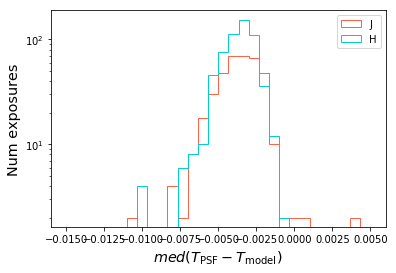

['J', 'H']
J
tomato
min and max mag:  14.5093393326 21.587688446
[ 14.50933933  14.86325679  15.21717424  15.5710917   15.92500916
  16.27892661  16.63284407  16.98676152  17.34067898  17.69459643
  18.04851389  18.40243134  18.7563488   19.11026626  19.46418371
  19.81810117  20.17201862  20.52593608  20.87985353  21.23377099
  21.58768845]
here
[ 14.86325679  15.21717424  15.5710917   15.92500916  16.27892661
  16.63284407  16.98676152  17.34067898  17.69459643  18.04851389
  18.40243134  18.7563488   19.11026626  19.46418371  19.81810117
  20.17201862  20.52593608  20.87985353  21.23377099  21.58768845]
median  -0.0125782159185
21 20 21
H
darkturquoise
min and max mag:  14.1017541885 21.587688446
[ 14.10175419  14.4760509   14.85034761  15.22464433  15.59894104
  15.97323775  16.34753447  16.72183118  17.09612789  17.4704246
  17.84472132  18.21901803  18.59331474  18.96761146  19.34190817
  19.71620488  20.09050159  20.46479831  20.83909502  21.21339173
  21.58768845]
here
[ 14.476

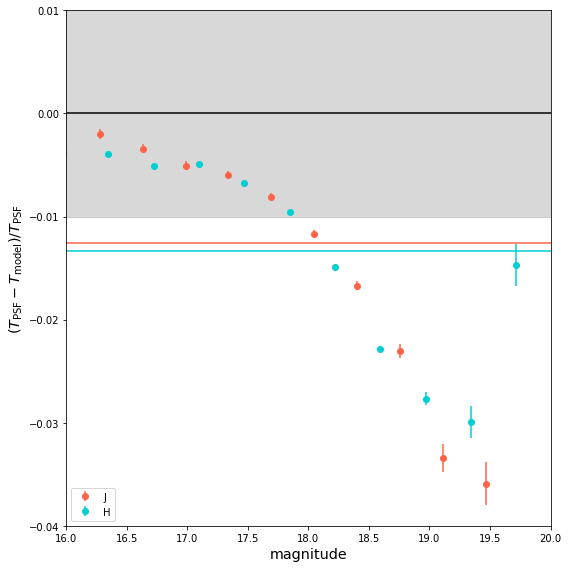

In [19]:
plt.hist(meddt["J"], 30,range=(-0.015,0.005),color="tomato",label="J",histtype='step')
plt.hist(meddt["H"], 30,range=(-0.015,0.005),color="darkturquoise",label="H",histtype='step')
#plt.hist(meddt["Ks"], 30,range=(-0.004,0.002),color="purple",label="Ks",histtype='step')
plt.xlabel(r'$ med(T_{\rm PSF} - T_{\rm model})$', fontsize='x-large')
plt.ylabel('Num exposures',fontsize='x-large')
#plt.title('%s'% band)
plt.yscale('log')
plt.legend()
plt.savefig('VIDEO_all_medresid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()

'''
fig, ax = plt.subplots()
hb=ax.hexbin(df['mag_aper'],df['sizeres'] ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.ylim(0,0.2)
plt.xlabel('%s mag_aper' %(band), fontsize='x-large')
plt.ylabel('T_res', fontsize='x-large')
plt.show()
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
'''

#subset=randomly_cull(df,80)
#keep=randomly_cull(df,percenttocut)
#stickplot(df['ra'],df['dec'], e1res, e2res, sizeres, fracsizeres, 1, 'no', 'no', 'no',0.03)
##print("done")
#med, mag_bins, bin_dtfrac,bin_dT_fracerr=bin_by_mag(df['mag_aper'], df['sizeres'], df['fracsizeres'], 15., band, name)

fig, axes = plt.subplots()   
plt.ylim(-0.04,0.01)
#plt.plot([min_mused,min_mused],[-1,1], color='Grey')
#plt.plot([19,19],[-1,1], color='Grey')
plt.fill( [16.,16.,20,20], [0.01,-0.01,-0.01,0.01], fill=True, color='grey',alpha=0.3)
#ax.fill( [min_mag,min_mag,min_mused,min_mused], [-1,1,1,-1], fill=True, color='Grey',alpha=0.3)
print(bands)
colour=["tomato","darkturquoise","purple"]
i=0
for band in bands:
    print(band)
    df=frames['%s'%band]
    #print(df.columns)
    print(colour[i])
    med, mag_bins, bin_dTfrac,bin_dTfrac_err=bin_by_mag(df['mag_aper'], df['sizeres'], df['fracsizeres'], 15., band, name)
    plt.plot([16.0,20.0], [med,med], color=colour[i])
    print(len(mag_bins),len(bin_dTfrac),len(bin_dTfrac_err))
    plt.errorbar(mag_bins[:-1], bin_dTfrac, yerr=bin_dTfrac_err[:-1], color=colour[i], fmt='o',label=band)
    i=i+1
plt.plot([16,20], [0,0], color='black')
plt.legend() #[t_line], [r'$\delta T$'])
plt.ylabel(r'$(T_{\rm PSF} - T_{\rm model})/ T_{\rm PSF}$', fontsize='x-large')
plt.xlim(16.0,20.0)
plt.xlabel('magnitude', fontsize='x-large')
fig.set_size_inches(8.0,8.0)
plt.tight_layout()
name='dpsf_VIDEO_all_DEEP.png' 
plt.savefig(name)
plt.show()

In [ ]:
  # Starfile has the following columns:
    # id: The original id from the SExtractor catalog
    # x: The x position
    # y: The y position
    # sky: The local sky value
    # noise: The estimated noise.  But these are all 0, so I think this isn't being calculated.
    # size_flags: Error flags that occurred when estimating the size
    # mag: The magnitude from SExtractor
    # sg: SExtractor's star/galaxy estimate.  Currently SPREAD_MODEL.  (Actually, currently none)
    # sigma0: The shapelet sigma that results in a b_11 = 0 shapelet parameter.
    # star_flag: 1 if findstars thought this was a star, 0 otherwise.
    
    #psfcat has the following columns:
    # name = 'VIGNET'; format = '3969E'; unit = 'count'; disp = 'G12.7'; dim = '(63, 63)'
    # name = 'XWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    # name = 'YWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    # name = 'X_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    # name = 'Y_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    # name = 'FLUX_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    # name = 'FLUXERR_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    # name = 'FLUX_MAX'; format = '1E'; unit = 'count'; disp = 'G12.7'
    # name = 'MAG_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    # name = 'MAGERR_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    # name = 'FLUX_RADIUS'; format = '1E'; unit = 'pixel'; disp = 'F10.3'
    # name = 'ELONGATION'; format = '1E'; disp = 'F8.3'
    # name = 'FLAGS'; format = '1I'; disp = 'I3'
    # name = 'SNR_WIN'; format = '1E'; disp = 'G10.4'
    # name = 'ERRAWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    # name = 'ERRBWIN_WORLD'; format = '1E'; unit = 'deg'; disp = 'G12.7'
    # name = 'ERRTHETAWIN_J2000'; format = '1E'; unit = 'deg'; disp = 'F6.2'

In [ ]:
# Now plot some results:                                                                                                 
print("All objs: ", len(df))
#good = (df['psfex_T'].values!=-999)&(df['obs_T'].values!=-999)
#df=df[good]
print("Good objs: ", len(df))
#resid_T = psf_t-star_t
#dtfrac = psf_t/star_t
#mag=df['mag_aper']#[good]

def compute_res(d):
    dt =  (d['obs_T']-d[prefix+'_T'])
    dtfrac = dt/d['obs_T']
    #print('mean dt = ',np.mean(dt))
    return dtfrac, dt 

prefix="psfex"
fracsizeres, sizeres=compute_res(df)

# Plotting the distribution of residuals                                                                                 
plt.hist(sizeres, 30)
plt.xlabel('T_res = PSF - obs', fontsize='x-large')
plt.ylabel('Num good objects',fontsize='x-large')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')
plt.figure(figsize=(12,12))
plt.show()

fig, ax = plt.subplots()
hb=ax.hexbin(df['mag_aper'],sizeres ,bins='log')#, marker='.', facecolors='lightblue', color='blue',alpha=0.2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('log10(N)')
plt.xlabel('mag_aper', fontsize='x-large')
plt.ylabel('T_res', fontsize='x-large')
#plt.savefig('UltraVISTA_J_resid.png',bbox_inches='tight')

bin_by_mag(df['mag_aper'], sizeres, fracsizeres, 15, band)


In [ ]:
6_52.59_-27.62